*Antonio Coín Castro*     


# Bayesian RKHS-based Functional Linear Regression

In [1]:
# -- Libraries

import os
import pickle

import arviz as az
import numpy as np
import pandas as pd

import utils.plot_utils as plot_utils
import rkbfr.bayesian_model as bayesian_model
import utils.run_utils as run_utils
import utils.simulation_utils as simulation

from IPython.display import display
from matplotlib import pyplot as plt
from scipy import stats
from skfda.datasets import fetch_cran, fetch_tecator
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.kernel_smoothers import \
    NadarayaWatsonSmoother as NW
from skfda.representation.basis import BSpline, Fourier
from skfda.representation.grid import FDataGrid
from sklearn.model_selection import KFold, train_test_split

from rkbfr.mle import compute_mle
from rkbfr.utils import pp_to_idata

/tmp/ipykernel_136983/3947336609.py:20: DeprecationWarning: The "kernel_smoothers" module is deprecated. Use the "KernelSmoother" class instead
  from skfda.preprocessing.smoothing.kernel_smoothers import \


In [2]:
# -- Configuration

# Extensions
# %load_ext autoreload
# %autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 2024
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)
pd.set_option("styler.format.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the model

$$
Y = \alpha_0 + \langle X, \alpha\rangle_K + \varepsilon,
$$

i.e.,

$$
Y_i\mid X_i=x_i \sim \mathcal N\left(\alpha_0 + \sum_{j=1}^p \beta_jx_i(\tau_j), \ \sigma^2\right).
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N_p(b_0, g\sigma^2{\underbrace{\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau) I\right]}_{G_\tau}}^{-1}),
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log\sigma)$, the joint log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$

## Example dataset

We generate a simulated dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, a value of $\alpha_0=5$ and a variance of $\sigma^2=0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 0.5\big)
$$

or

$$
Y_i \sim \mathcal N\left(5 + \int_0^1 \log(1+4t)X_i(t)\, dt, \ 0.5\right).
$$

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms. We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation (in terms of the RMSE of prediction).

In [3]:
# -- Data generation parameters

SYNTHETIC_DATA = True
REGRESSOR_GEN = "GP"  # 'GP' or 'GBM'
MODEL_GEN = "RKHS"  # 'L2' or 'RKHS'
REAL_DATA = "Moisture"

INITIAL_SMOOTHING = None  # None, 'NW' or 'Basis'
N_BASIS = 16  # Number of basis elements for expansion
SCALE_PREDICTORS = False
STANDARDIZE_RESPONSE = False

n_train, n_test = 100, 50
N = 100
tau_range = (0, 1)

mean_vector = np.zeros(N)
kernel_fn = simulation.brownian_kernel
smoothing_params = np.logspace(-4, 4, 50)

In [4]:
# -- Dataset generation

if SYNTHETIC_DATA:
    grid = np.linspace(tau_range[0] + 1./N, tau_range[1], N)
    alpha0_true = 5.
    sigma2_true = 0.5

    # Generate X
    if REGRESSOR_GEN == "GP":
        x = simulation.gp(
            grid,
            mean_vector,
            kernel_fn,
            n_train + n_test,
            rng
        )
    else:  # GBM
        x = np.exp(
            simulation.gp(
                grid,
                mean_vector,
                simulation.brownian_kernel,
                n_train + n_test,
                rng
            ))

    # Generate Y
    if MODEL_GEN == "L2":
        beta_coef = simulation.cholaquidis_scenario3
        y = simulation.generate_l2_dataset(
            x,
            grid,
            beta_coef,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    elif MODEL_GEN == "RKHS":
        beta_true = [-5., 10.]
        tau_true = [0.1, 0.8]
        y = simulation.generate_rkhs_dataset(
            x,
            grid,
            beta_true,
            tau_true,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    else:
        raise ValueError("Invalid model generation strategy.")

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x, y, train_size=n_train, random_state=SEED)

    # Create FData object
    X_fd = FDataGrid(X, grid)
    X_test_fd = FDataGrid(X_test, grid)

else:  # Real data
    if REAL_DATA == "Tecator":
        x, y = fetch_tecator(return_X_y=True)
        data = x.data_matrix[..., 0]
        u, idx = np.unique(data, axis=0, return_index=True)
        x = FDataGrid(data[idx], x.grid_points[0]).derivative(order=2)
        y = y[idx, 1]  # Fat level
    elif REAL_DATA == "Moisture":
        data = fetch_cran(
            "Moisturespectrum", "fds")["Moisturespectrum"]
        y = fetch_cran(
            "Moisturevalues", "fds")["Moisturevalues"]
        x = FDataGrid(data["y"].T[:, ::7], data["x"][::7])
    elif REAL_DATA == "Sugar":
        data = np.load('data/sugar.npz')
        x = FDataGrid(data['x'][:, ::5])
        y = data['y']
    else:
        raise ValueError("REAL_DATA must be 'Tecator', 'Moisture' or 'Sugar'.")

    N = len(x.grid_points[0])
    grid = simulation.normalize_grid(
        x.grid_points[0], tau_range[0], tau_range[1])

    x = FDataGrid(x.data_matrix, grid)

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.667, random_state=SEED)

    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Smooth data

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        basis = BSpline(n_basis=N_BASIS)
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    X_fd, best_smoother, X_test_fd = simulation.smooth_data(
        X_fd,
        smoother,
        smoothing_params,
        X_test_fd
    )

    print(
        "Smoother: {}".format(
            best_smoother.best_estimator_.__class__.__name__))
    print(
        "Smoothing parameter: {:.3f}".format(
            best_smoother.best_params_['smoothing_parameter']))

# Standardize data
X_fd, X_test_fd, _, _ = simulation.standardize_predictors(
    X_fd, X_test_fd, SCALE_PREDICTORS)

if STANDARDIZE_RESPONSE:
    Y, Y_test, _, _ = simulation.standardize_response(Y, Y_test)

# Get data matrices

X = X_fd.data_matrix.reshape(-1, N)
X_test = X_test_fd.data_matrix.reshape(-1, N)

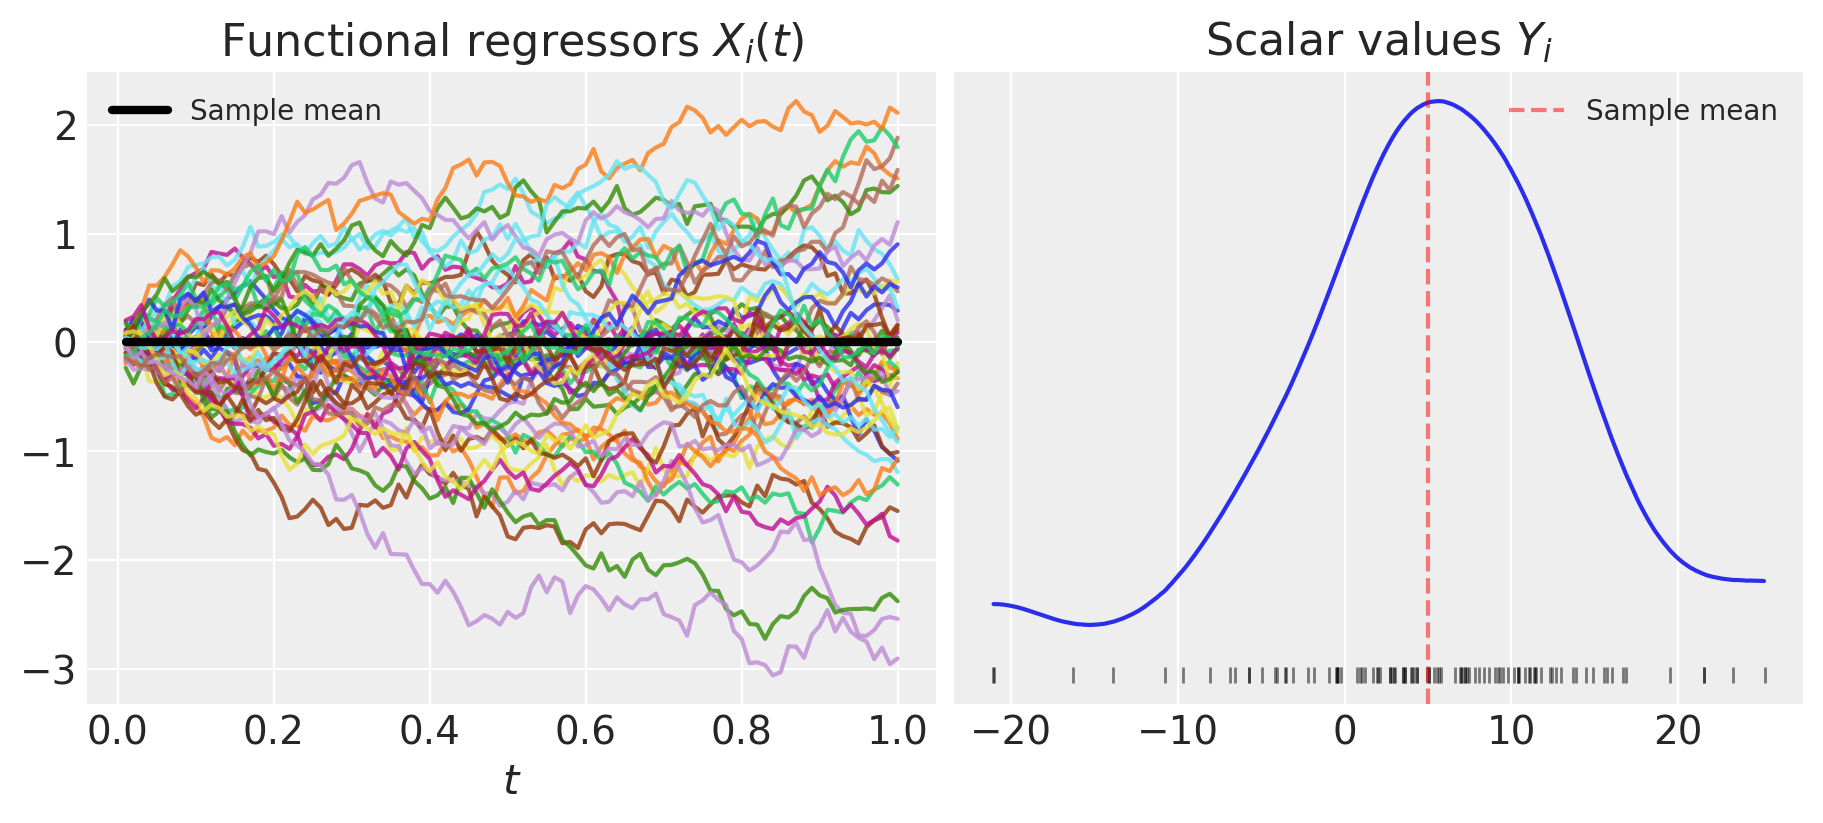

In [5]:
# -- Dataset visualization

plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train if not SYNTHETIC_DATA else n_train//2,
)

## Common model hyperparameters

In [6]:
# -- Model hyperparameters

p_max = 3
g = 5
eta = 1e-5

PRIOR_P_MANUAL = False
if PRIOR_P_MANUAL:
    prior_p = {
        1: 0.10,
        2: 0.60,
        3: 0.30,
    }
else:
    lambda_param = 4
    p_range = range(1, p_max + 1)
    p_probs = [stats.poisson.pmf(p, mu=lambda_param, loc=1) for p in p_range]
    p_probs = p_probs/np.sum(p_probs)
    prior_p = {p: x for x, p in zip(p_probs, p_range)}

mle_method = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
mle_strategy = 'global'
beta_range = None
sigma2_ub = np.inf
relabel_strategy = 'auto'

INCLUDE_P = False
TRANSFORM_TAU = False
TRANSFORM_SIGMA = True
PRIOR_TAU = None  # 'None' --> uniform, 'auto' --> beta
FIT_SK = True
COMPUTE_MLE = True

In [7]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if INCLUDE_P:
    theta_names = ["p"] + theta_names

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]
if INCLUDE_P:
    theta_labels_grouped = [r"$p$"] + theta_labels_grouped

# Individual labels
theta_labels = [] if not INCLUDE_P else [theta_labels_grouped[0]]
for i in range(p_max):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_max):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
dim_name = "theta"
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={dim_name: dict(
        zip(np.arange(p_max), np.arange(1, p_max + 1)))}
)

In [8]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

if TRANSFORM_SIGMA:
    sigma2_ttr = bayesian_model.LogSq()
else:
    sigma2_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_max,
    grid,
    include_p=INCLUDE_P,
    names=theta_names,
    labels=theta_labels,
    labeller=theta_labeller,
    tau_range=tau_range,
    beta_range=beta_range,
    tau_ttr=tau_ttr,
    sigma2_ttr=sigma2_ttr,
    sigma2_ub=sigma2_ub
)

# Statistics for posterior predictive checks
point_estimators_bpv = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)
]

# Folds for CV
folds = KFold(shuffle=True, random_state=SEED)

# Column to order results
sort_by = -2

## Sklearn model comparison

In [9]:
# -- Select family of regressors

alphas = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, 50]
n_components = [2, 3, 4, 5, 7, 10, 15, 20]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]

basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]

params_regularizer = {"reg__alpha": alphas}
params_select = {"selector__p": n_selected}
params_pls = {"reg__n_components": n_components}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}

regressors = run_utils.linear_regression_comparison_suite(
    params_regularizer,
    params_select,
    params_dim_red,
    params_basis,
    params_pls,
    random_state=SEED
)

/tmp/ipykernel_136983/793983393.py:9: DeprecationWarning: The BSpline class is deprecated. Use BSplineBasis instead.
  basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
/tmp/ipykernel_136983/793983393.py:10: DeprecationWarning: The Fourier class is deprecated. Use FourierBasis instead.
  basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]


In [10]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, reg_cv = run_utils.cv_sk(
        regressors,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        folds,
        kind='linear',
        n_jobs=N_CORES,
        sort_by=sort_by,
        verbose=True
    )
    display(df_metrics_sk.style.hide(axis="index"))

  Fitting lasso...
  Fitting ridge...
  Fitting pls1...
  Fitting manual+ridge...
  Fitting fpca+ridge...
  Fitting pca+ridge...
  Fitting pls+ridge...
  Fitting apls...
  Fitting flin...
  Fitting fpls1...


## Maximum Likelihood Estimator

Here is an example of MLE approximation. We can use the MLE as a predictor as well, following our model.

In [11]:
# -- MLE computation

if COMPUTE_MLE:
    print(f"-- Computing MLE with {N_CORES} independent runs --")

    theta_space_fixed = theta_space.copy_p_fixed()

    mle_theta, bic = compute_mle(
        X,
        Y,
        theta_space_fixed,
        kind='linear',
        method=mle_method,
        strategy=mle_strategy,
        n_jobs=N_CORES,
        rng=rng
    )

    Y_pred_mle = bayesian_model.generate_response_linear(
        X_test, mle_theta, theta_space_fixed, noise=False
    )

    df_metrics_mle = run_utils.linear_regression_metrics(
        Y_test,
        Y_pred_mle,
        theta_space.p_max,
        "mle"
    )
    print(f"\nBIC [p={p_max}]: {bic:.3f}")
    display(pd.DataFrame(zip(theta_space_fixed.labels, mle_theta),
                         columns=["", "MLE"]).style.hide(axis="index"))
    print("Regression metrics:")
    display(df_metrics_mle.style.hide(axis="index"))

-- Computing MLE with 4 independent runs --

BIC [p=3]: 172.892


Regression metrics:


## The Ensemble Sampler and the *emcee* library

In [12]:
from rkbfr.mcmc_sampler import BFLinearEmcee
import emcee

### Experiments

A fast overview of the inference a prediction procedure is shown if `FAST_RUN` is set to True.

In [13]:
# -- Sampler parameters

n_walkers = 32
n_iter_warmup = 100
n_iter = 1500

compute_pp = False
compute_ll = False
frac_random = 0.3

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5
burn = 500

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [14]:
# -- Run sampler

print("-- Running affine-invariant ensemble sampler "
      f"with {N_CORES} cores --")

reg_emcee = BFLinearEmcee(
    theta_space,
    n_walkers,
    n_iter,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    prior_tau=PRIOR_TAU,
    n_iter_warmup=n_iter_warmup,
    initial_state='mle',
    frac_random=frac_random,
    relabel_strategy=relabel_strategy,
    moves=moves,
    compute_pp=compute_pp,
    compute_ll=compute_ll,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    progress_notebook=True,
    random_state=rng,  # change to 'SEED' for the same output each time
)

if FAST_RUN:
    df_metrics_emcee = run_utils.run_bayesian_model(
        reg_emcee,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='linear',
        prefix='emcee',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        sort_by=sort_by,
        verbose=True,
        notebook=True,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE and "df_metrics_mle" in globals():
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_mle])
        if FIT_SK and "df_metrics_sk" in globals():
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_sk])

        df_metrics_emcee.sort_values(
            df_metrics_emcee.columns[sort_by],
            inplace=True
        )
        display(df_metrics_emcee.style.hide(axis="index"))
else:
    reg_emcee.fit(X, Y)
    print(f"Mean acceptance: {100*reg_emcee.mean_acceptance():.3f}%")

idata_emcee = reg_emcee.get_idata()

-- Running affine-invariant ensemble sampler with 4 cores --
[BFLinearEmcee] Computing MLE...
[BFLinearEmcee] MCMC warmup iterations...


/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/emcee/pbar.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  return getattr(tqdm, "tqdm_" + display)(total=total, **kwargs)


[BFLinearEmcee] MCMC:   0%|          | 0/1500 [00:00<?, ?it/s]

[BFLinearEmcee] Discarding the first 500 samples...
Mean acceptance: 18.908%


/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


mean     sd  hdi_3%  hdi_97%    min     max  median   mode
β[1]       -4.757  0.338  -5.250   -4.181 -6.112  -3.664  -4.746 -4.800
β[2]        0.035  1.103  -3.637    1.693 -4.198   5.493   0.090  0.070
β[3]        9.699  0.898   7.212   10.402  6.576  14.089   9.763  9.826
τ[1]        0.101  0.015   0.095    0.137  0.032   0.163   0.101  0.101
τ[2]        0.646  0.265   0.124    0.984  0.000   1.000   0.724  0.851
τ[3]        0.800  0.004   0.795    0.805  0.776   0.851   0.799  0.796
$\alpha_0$  4.993  0.071   4.859    5.126  4.740   5.292   4.993  4.967
$\sigma^2$  1.215  2.836   0.319    6.051  0.278  15.687   0.473  0.474


Computing metrics...

Generating posterior predictive samples...


/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)
/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)
/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.

### Analysis

The effective sample size is computed as suggested [here (p.66)](https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/mcmc_slides.pdf) (missing values are replaced with a value of $0$).

In [15]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Get number of samples
n_samples_emcee = reg_emcee.total_samples()

# Get autocorrelation times
autocorr = reg_emcee.autocorrelation_times()

pd.DataFrame(
    zip(theta_labels, autocorr, n_samples_emcee/autocorr),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide(axis="index")

/home/antcc/Académico/MCD/TFM/rk-bfr/rkbfr/mcmc_sampler.py:287: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples = (self.idata_.posterior.dims["chain"]
/home/antcc/Académico/MCD/TFM/rk-bfr/rkbfr/mcmc_sampler.py:288: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  * self.idata_.posterior.dims["draw"])
The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 75.796  79.812  82.472  80.906 101.586  86.548  80.858  87.441]


In [16]:
# -- Trace summary

reg_emcee.summary()

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


mean     sd  hdi_3%  hdi_97%    min     max  median   mode
β[1]       -4.757  0.338  -5.250   -4.181 -6.112  -3.664  -4.746 -4.800
β[2]        0.035  1.103  -3.637    1.693 -4.198   5.493   0.090  0.070
β[3]        9.699  0.898   7.212   10.402  6.576  14.089   9.763  9.826
τ[1]        0.101  0.015   0.095    0.137  0.032   0.163   0.101  0.101
τ[2]        0.646  0.265   0.124    0.984  0.000   1.000   0.724  0.851
τ[3]        0.800  0.004   0.795    0.805  0.776   0.851   0.799  0.796
$\alpha_0$  4.993  0.071   4.859    5.126  4.740   5.292   4.993  4.967
$\sigma^2$  1.215  2.836   0.319    6.051  0.278  15.687   0.473  0.474

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)
/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)
/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.

Combined density and trace plot:


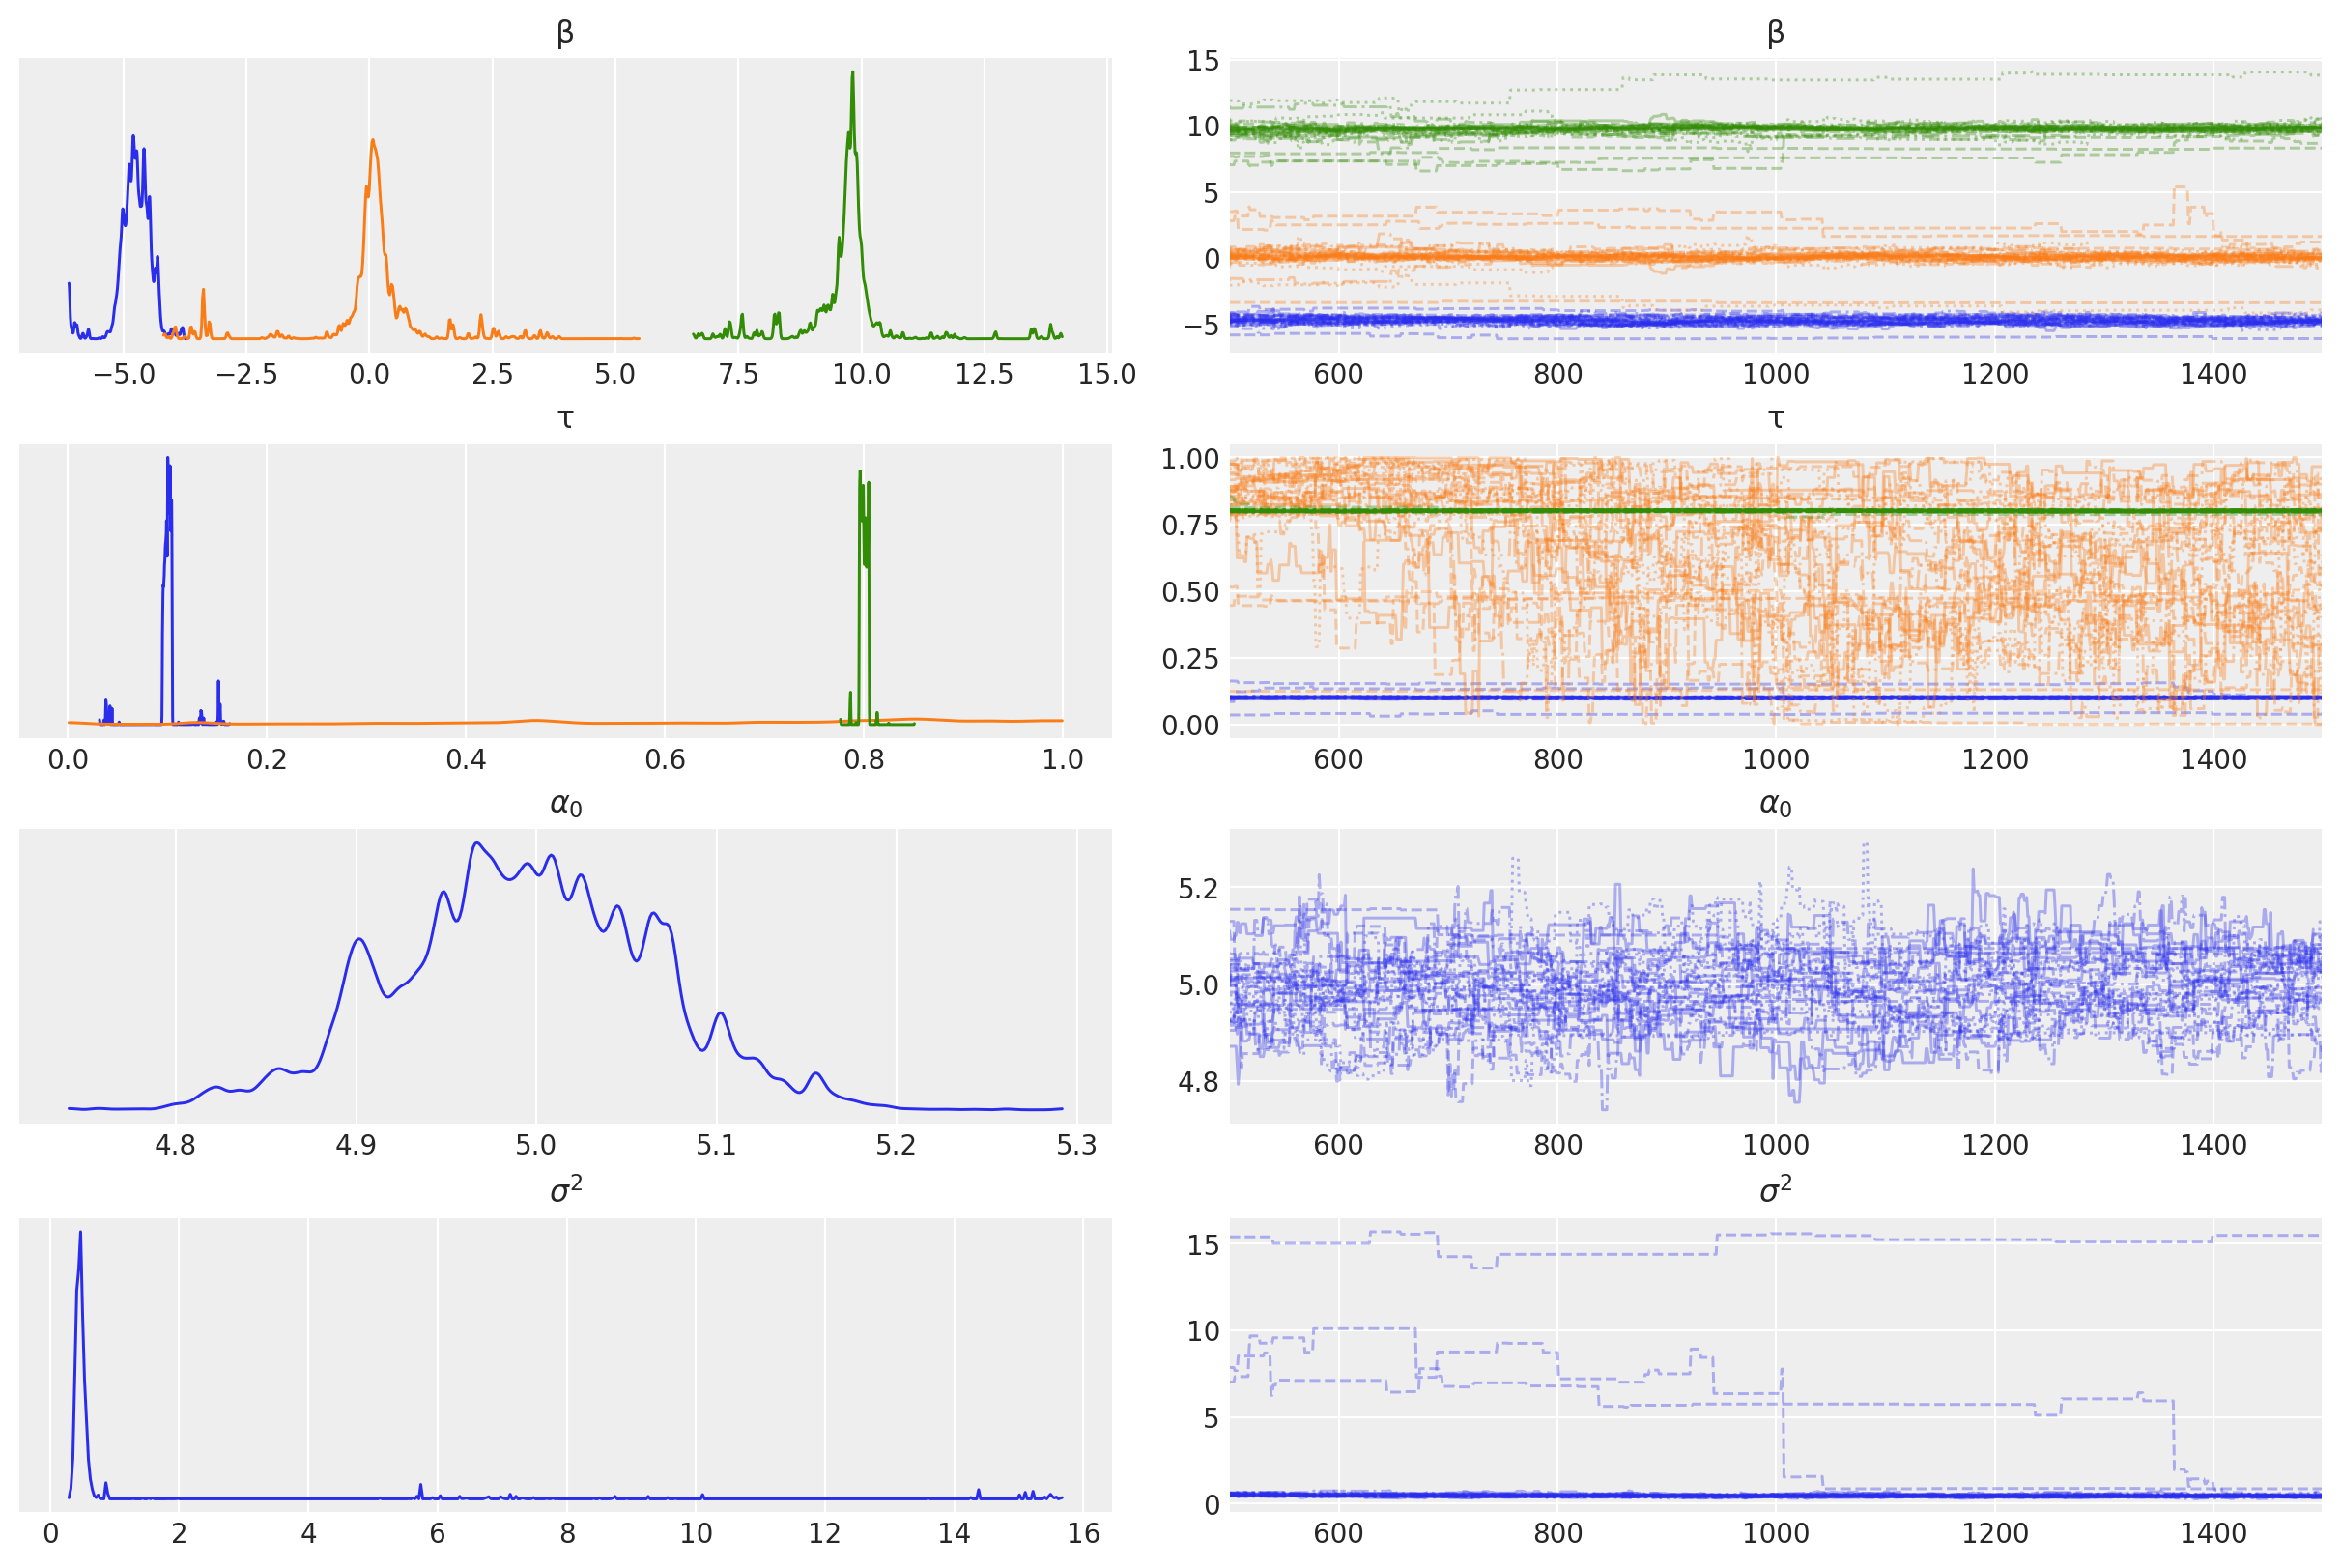

In [17]:
# -- Trace plot

az.plot_trace(
    idata_emcee,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)

print("Combined density and trace plot:")

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


Marginal posterior distributions:


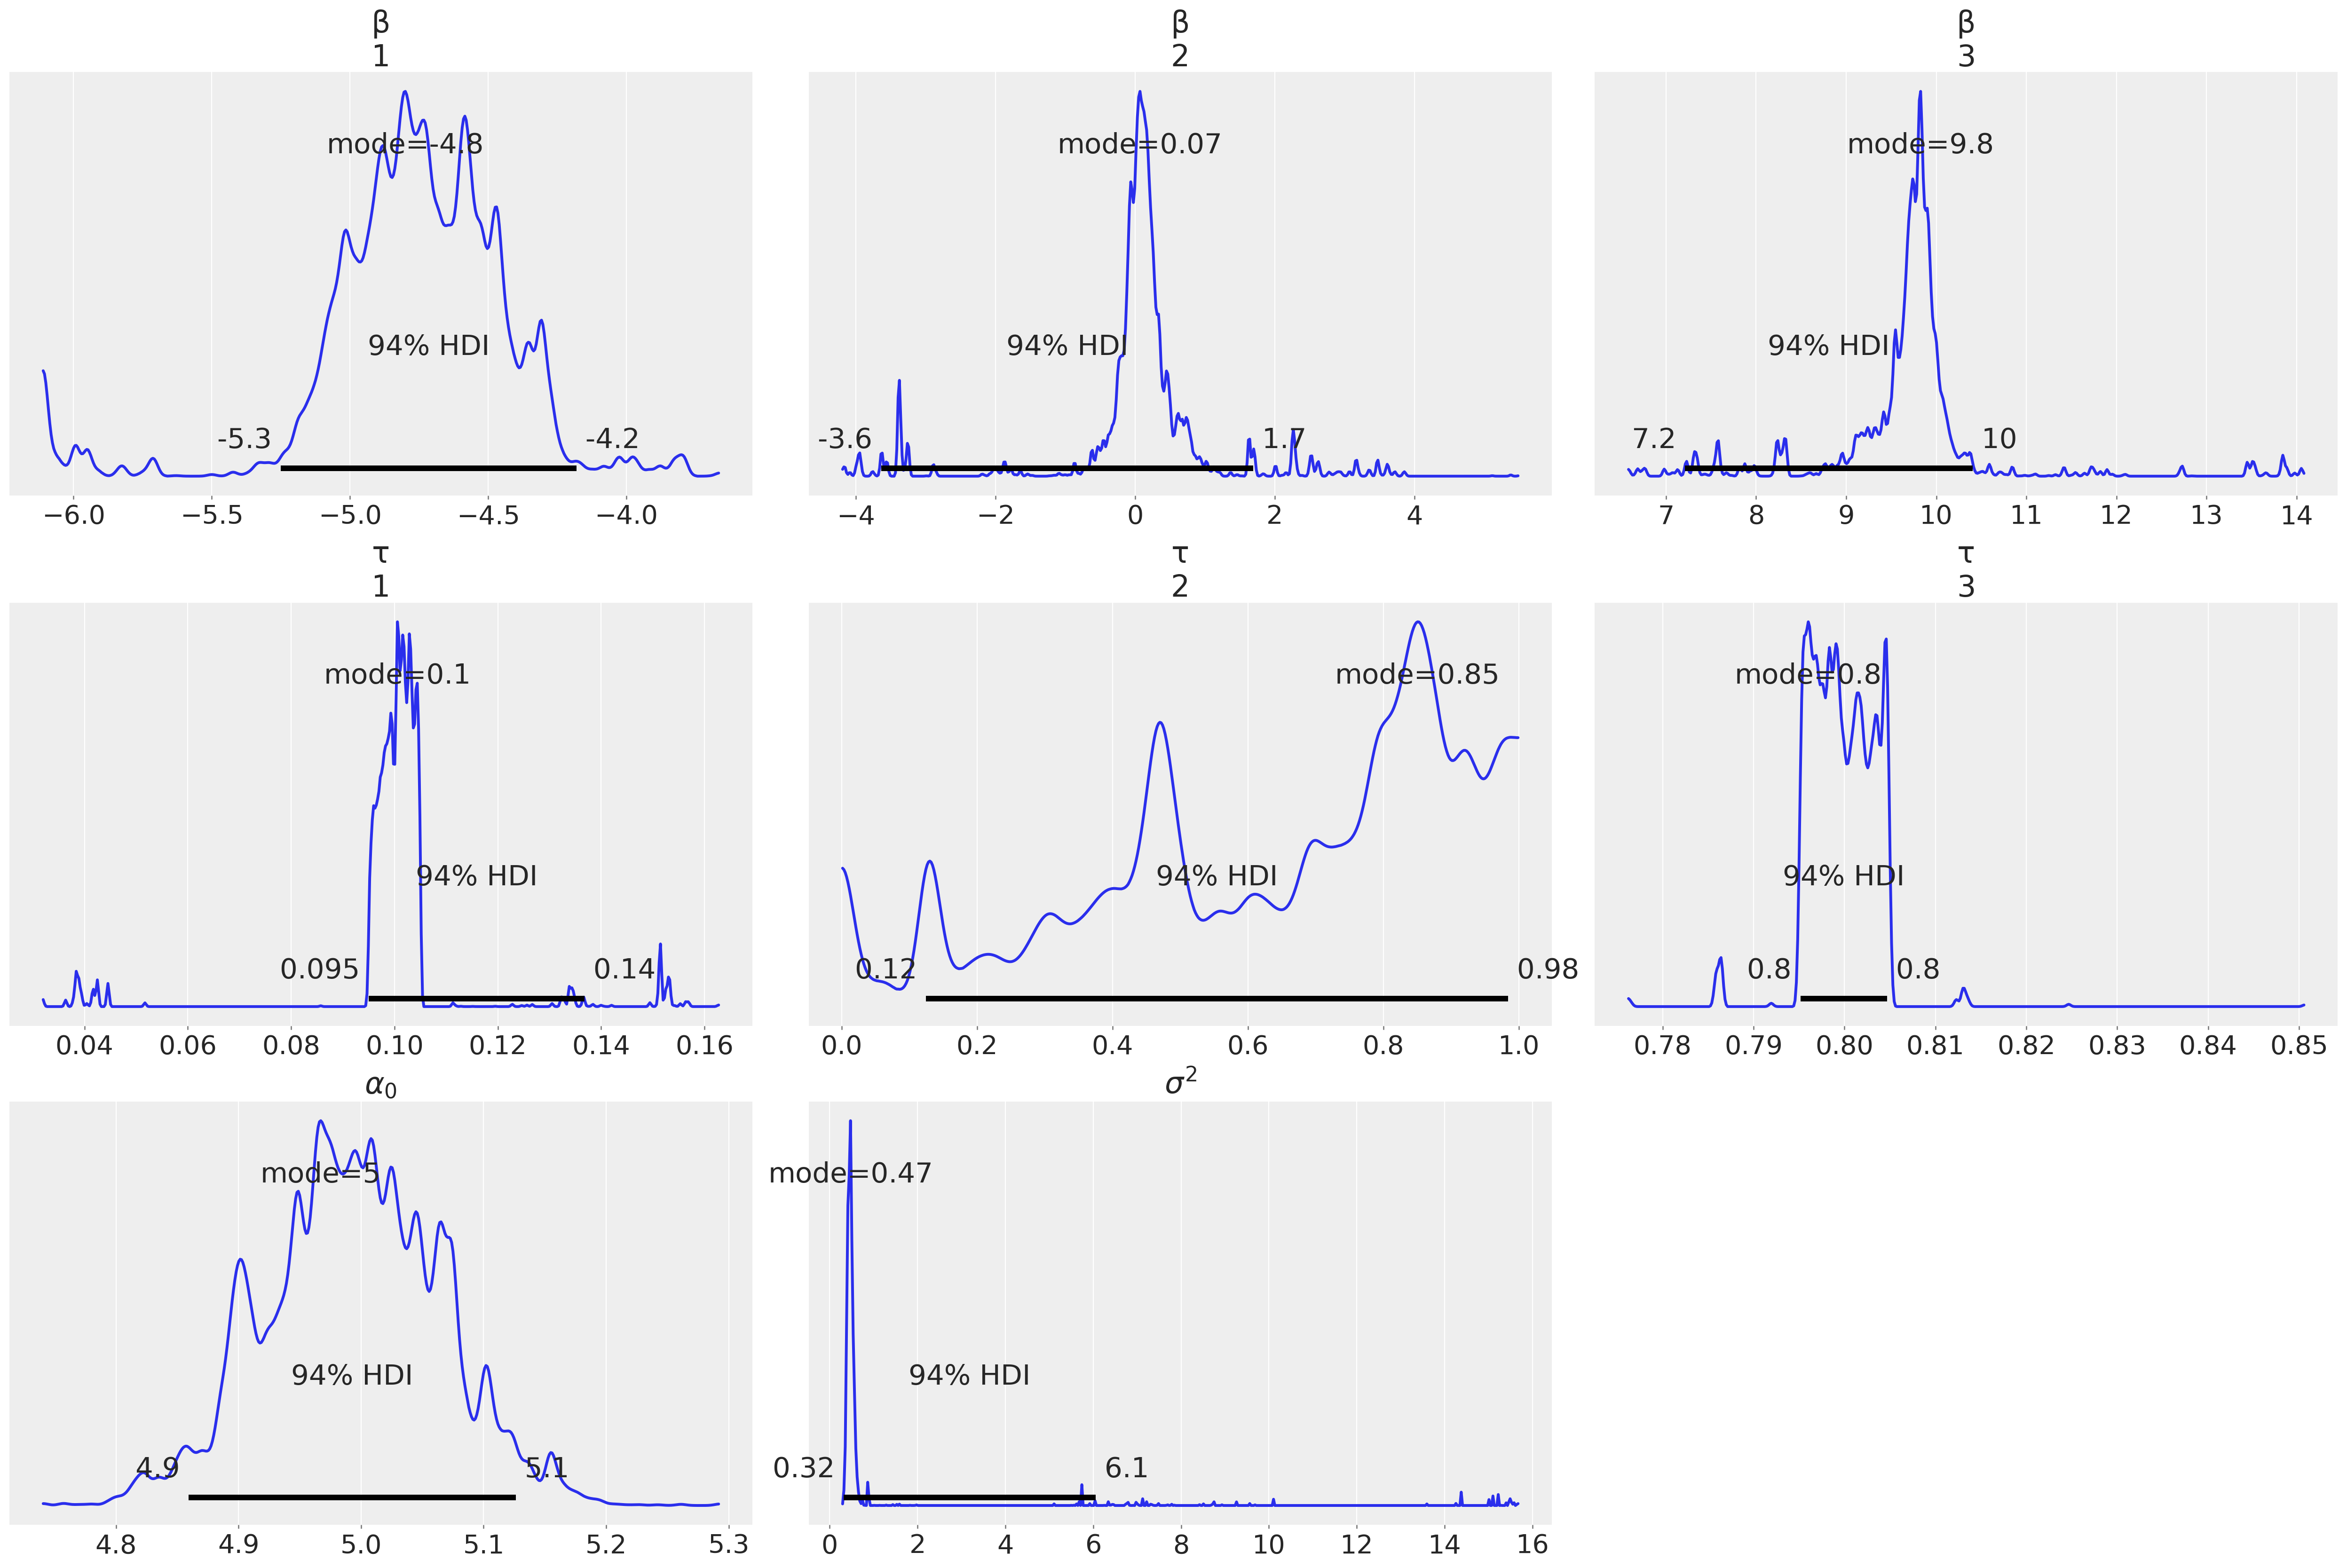

In [18]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Forest plot of 94% HDI for β and τ:


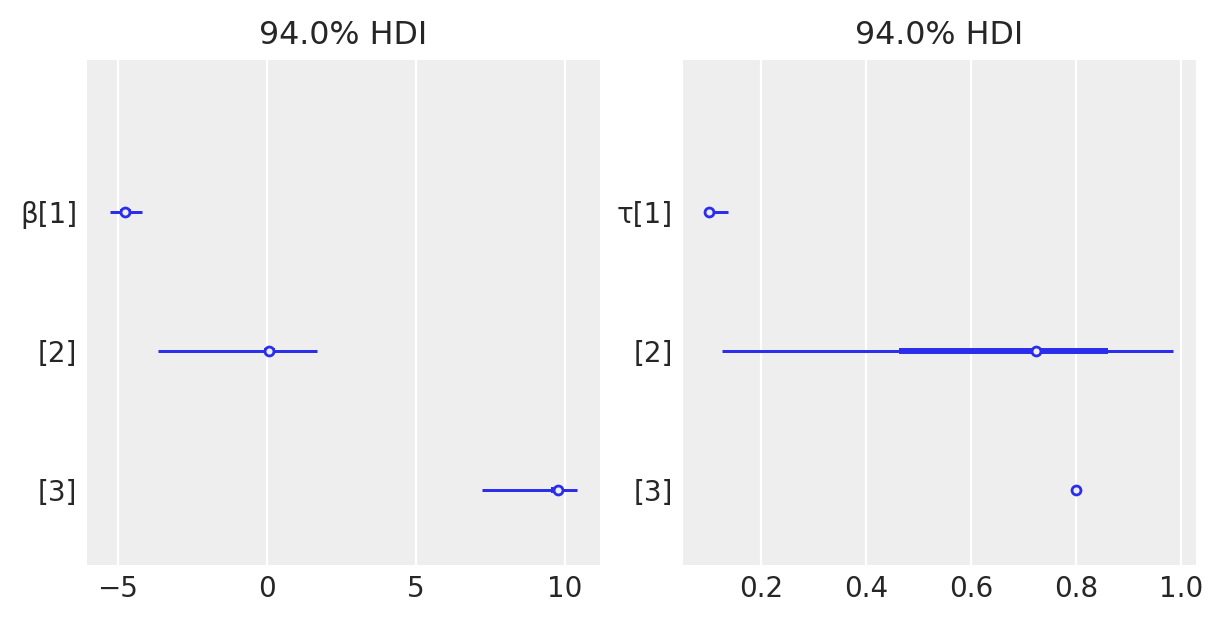

In [19]:
# -- Forest plot

plot_utils.plot_forest(
    idata_emcee,
    theta_space,
    textsize=10,
    var_names=[theta_names[theta_space.beta_idx_grouped],
               theta_names[theta_space.tau_idx_grouped]]
)

print("Forest plot of 94% HDI for β and τ:")

We can perform a couple of visual posterior predictive checks. In particular:
    
- A plot of the distribution of $Y$ and the distribution of $\{Y^*_m\}_m$ (one for every sample $\theta_m$ of the chain), generated using the original traning data $X$.
- A plot of the distribution of $T(Y^*)$, where $T(x)=\bar x$. 

We also show the Bayesian p-value for several statistics, which is defined as $P(T(y^*)\leq T(y)\mid y)$, and is computed by simply measuring the proportion of generated samples $\{T(Y^*_m)\}_m$ that fall below the observed value of the statistic. It is expected to be around $0.5$ when the model accurately represents the data.

Generating posterior predictive samples...


/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


bpv [T=min]: 0.767
bpv [T=max]: 0.708
bpv [T=median]: 0.154
bpv [T=mean]: 0.518
bpv [T=std]: 0.499


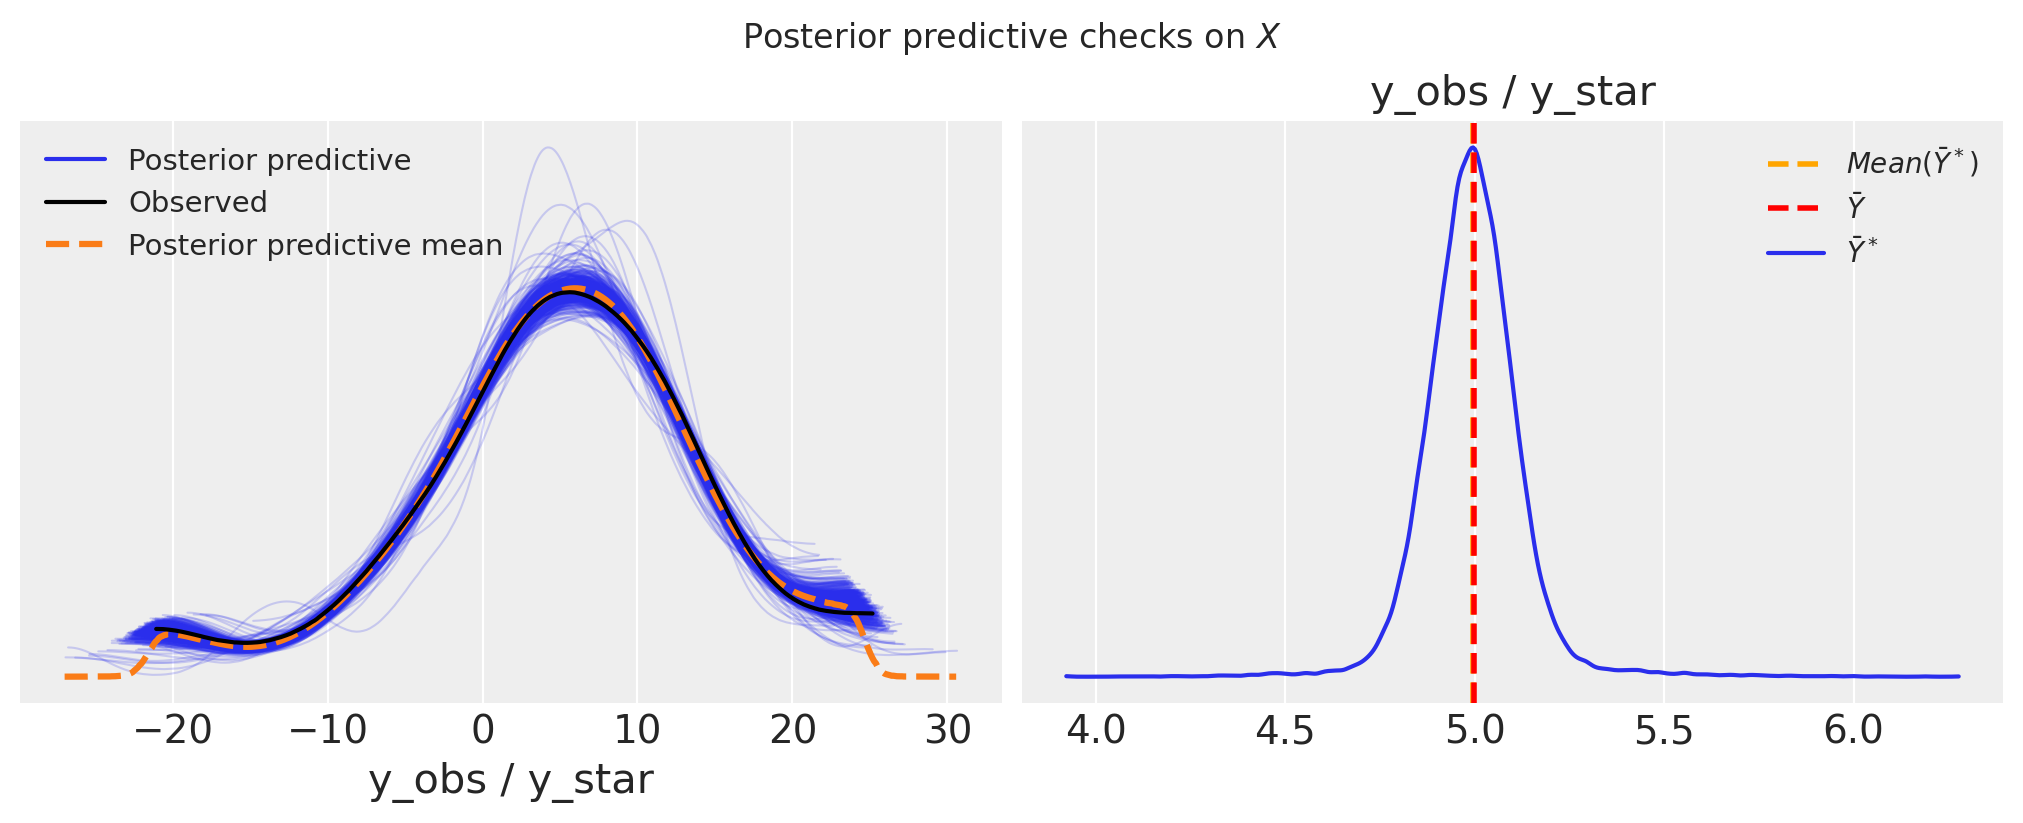

In [20]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp = bayesian_model.generate_pp(
        idata_emcee, X, theta_space,
        rng=rng, kind='linear', verbose=True)
    pp_to_idata([pp], idata_emcee, ['y_star'], merge=True)
else:
    pp = idata_emcee.posterior_predictive['y_star'].to_numpy()

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_emcee, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


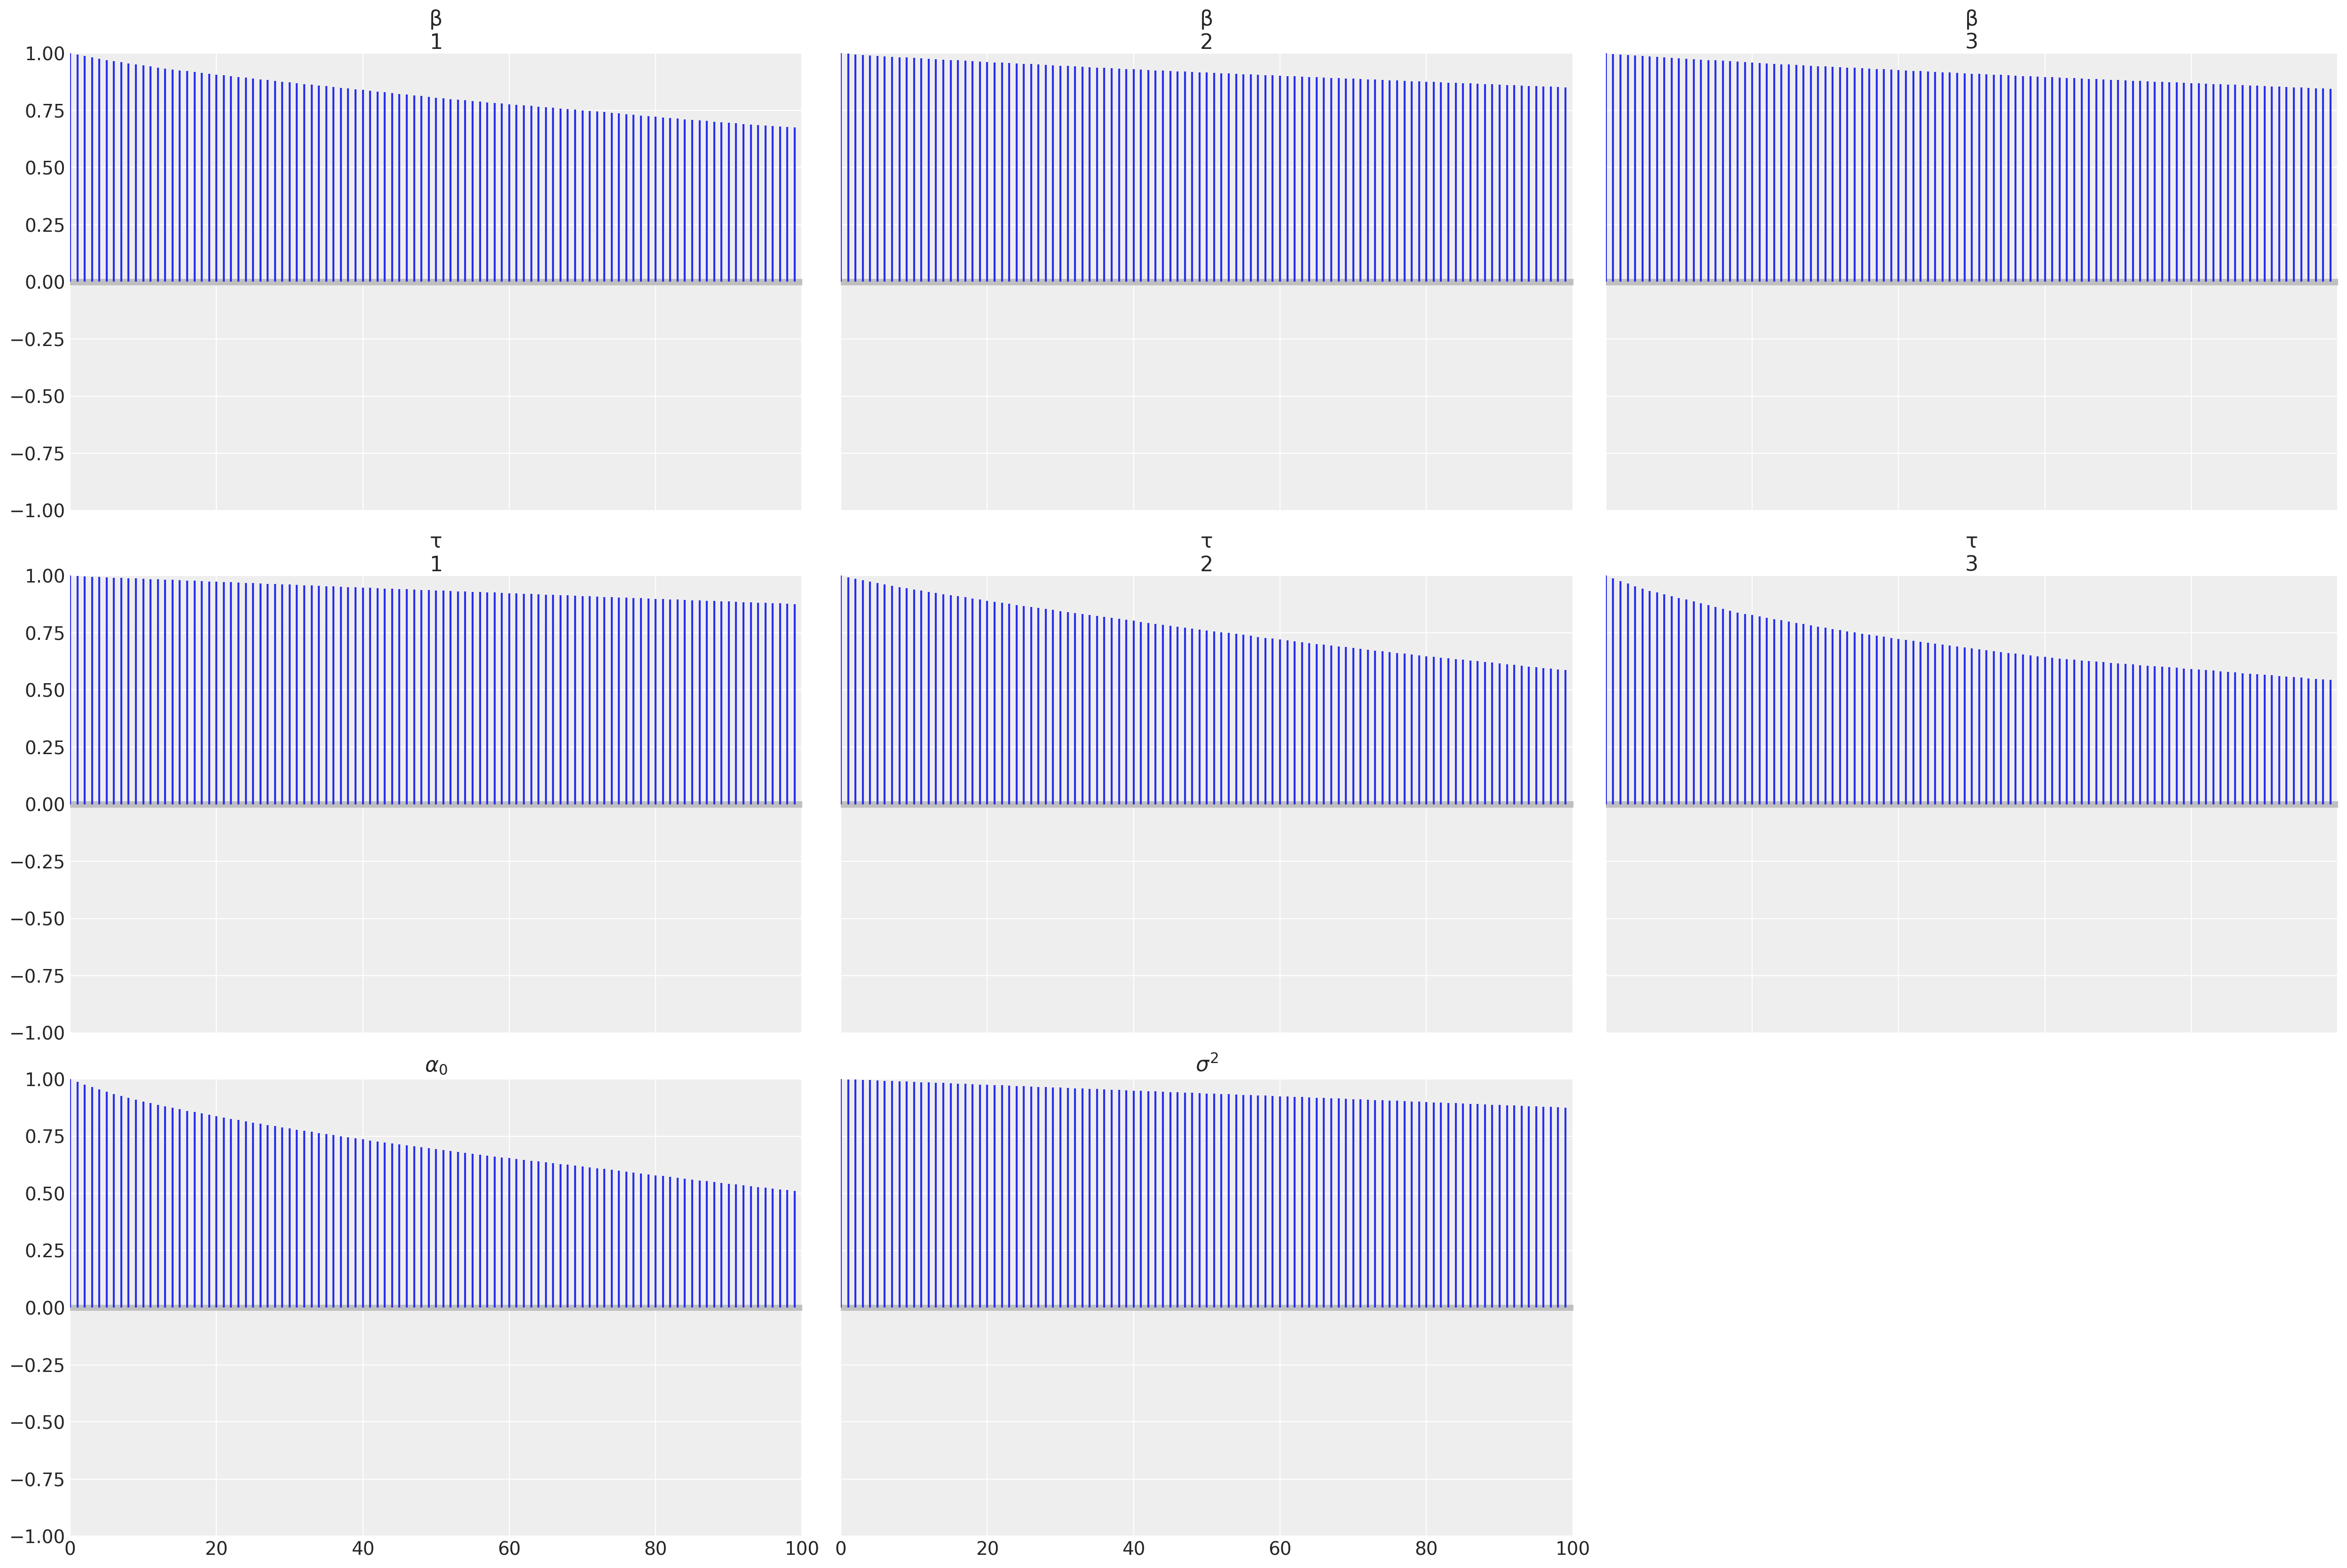

In [21]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

### Out-of-sample predictions

First we take a look at the posterior predictive distribution on a previously unseen dataset.

Generating posterior predictive samples...


/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


bpv [T=min]: 0.458
bpv [T=max]: 0.612
bpv [T=median]: 0.543
bpv [T=mean]: 0.213
bpv [T=std]: 0.970


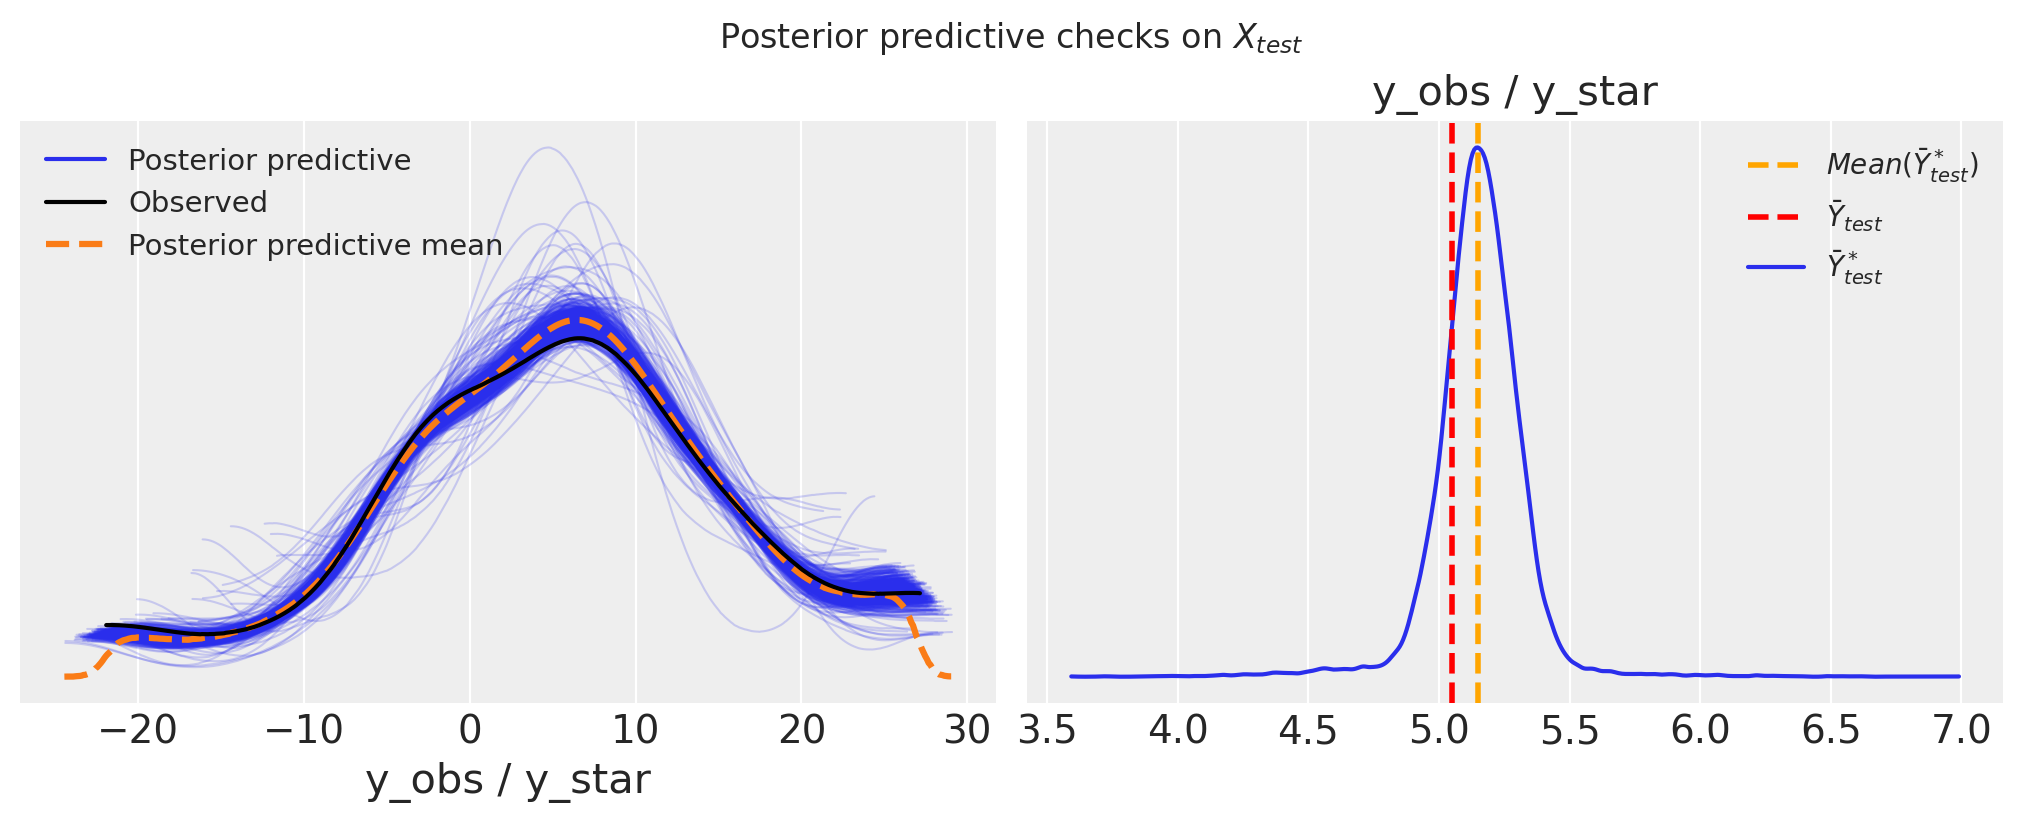

In [22]:
# -- Generate and plot posterior predictive checks from X_test

# Posterior predictive checks
pp_test = bayesian_model.generate_pp(
    idata_emcee,
    X_test,
    theta_space,
    rng=rng,
    kind='linear',
    verbose=True,
)
idata_pp_test = pp_to_idata(
    [pp_test], idata_emcee, ['y_star'], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the RMSE when using several point-estimates for the parameters, as well as the mean of the posterior samples.

In [23]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_emcee = run_utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_emcee.n_components("posterior_mean"),
    "emcee_posterior_mean"
)

# Point estimates
for pe in reg_emcee.default_point_estimates:
    Y_pred_pe = reg_emcee.predict(X_test, strategy=pe)
    df_metrics_emcee = run_utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_emcee.n_components(pe),
        "emcee_" + pe,
        df=df_metrics_emcee,
    )

df_metrics_emcee.style.hide(axis="index")

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


In [24]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = None

for pe in reg_emcee.default_point_estimates:
    X_red = reg_emcee.transform(X, pe=pe)
    X_test_red = reg_emcee.transform(X_test, pe=pe)

    df_metrics_emcee_var_sel = run_utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        pe=pe,
        df=df_metrics_emcee_var_sel,
        random_state=SEED
    )

df_metrics_emcee_var_sel.style.hide(axis="index")

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)
/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [25]:
# -- Save

with open("emcee-linear.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [26]:
# -- Load

with open("emcee-linear.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [27]:
from rkbfr.mcmc_sampler import BFLinearPymc
import pymc as pm

### Experiments

In [28]:
# -- Sampler parameters

n_chains = N_CORES
USE_NUTS = False

if USE_NUTS:
    n_samples = 500
    n_tune = 500
    step_fn = pm.NUTS
    step_kwargs = {"target_accept": 0.8}
else:
    n_samples = 5000
    n_tune = 5000
    step_fn = pm.Metropolis
    step_kwargs = {}

burn = 0
thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [29]:
# -- Run sampler

print(f"-- Running pymc sampler with {N_CORES} cores --")

reg_pymc = BFLinearPymc(
    theta_space,
    n_chains,
    n_samples,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    prior_tau=PRIOR_TAU,
    step_fn=step_fn,
    step_kwargs=step_kwargs,
    n_iter_warmup=n_tune,
    relabel_strategy=relabel_strategy,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    random_state=rng  # change to 'SEED' for the same output each time
)

if FAST_RUN:
    df_metrics_pymc = run_utils.run_bayesian_model(
        reg_pymc,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='linear',
        prefix='pymc',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        sort_by=sort_by,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE and "df_metrics_mle" in globals():
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_mle])
        if FIT_SK and "df_metrics_sk" in globals():
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_sk])

        df_metrics_pymc.sort_values(
            df_metrics_pymc.columns[sort_by],
            inplace=True
        )
        display(df_metrics_pymc.style.hide(axis="index"))
else:
    reg_pymc.fit(X, Y)
    print(f"Mean acceptance: {100*reg_pymc.mean_acceptance():.3f}%")

idata_pymc = reg_pymc.get_idata()

-- Running pymc sampler with 4 cores --
[BFLinearPymc] Computing MLE...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [α0_and_LogSq σ2]
>Metropolis: [τ_unordered]
>Metropolis: [β_unbounded]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 32 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


[BFLinearPymc] Discarding the first 0 samples...
Mean acceptance: 30.583%


/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


mean     sd  hdi_3%  hdi_97%     min     max  median   mode
β[1]       -2.565  3.690 -10.317    1.049 -12.697   2.080  -0.824 -0.676
β[2]       -2.416  3.733  -5.684    5.634  -7.015   7.718  -4.238 -4.353
β[3]        9.870  0.073   9.729   10.005   9.563  10.167   9.869  9.864
τ[1]        0.078  0.018   0.049    0.104   0.010   0.105   0.080  0.097
τ[2]        0.101  0.003   0.096    0.105   0.095   0.133   0.101  0.105
τ[3]        0.800  0.003   0.795    0.805   0.795   0.805   0.800  0.796
$\alpha_0$  4.997  0.068   4.872    5.124   4.758   5.238   4.997  4.996
$\sigma^2$  0.445  0.065   0.334    0.570   0.253   0.779   0.441  0.444

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)



Computing metrics...

Generating posterior predictive samples...


/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)
/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


### Analysis

In [30]:
# -- Trace summary

reg_pymc.summary(stats='all')

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[1]       -2.565  3.690 -10.317    1.049      1.783    1.358       7.0   
β[2]       -2.416  3.733  -5.684    5.634      1.810    1.380       7.0   
β[3]        9.870  0.073   9.729   10.005      0.001    0.001    2509.0   
τ[1]        0.078  0.018   0.049    0.104      0.006    0.005       8.0   
τ[2]        0.101  0.003   0.096    0.105      0.001    0.000      52.0   
τ[3]        0.800  0.003   0.795    0.805      0.000    0.000    3354.0   
$\alpha_0$  4.997  0.068   4.872    5.124      0.001    0.001    3407.0   
$\sigma^2$  0.445  0.065   0.334    0.570      0.001    0.001    3883.0   

            ess_tail  r_hat     min     max  median   mode  
β[1]            24.0   1.57 -12.697   2.080  -0.824 -0.676  
β[2]            24.0   1.57  -7.015   7.718  -4.238 -4.353  
β[3]          3364.0   1.00   9.563  10.167   9.869  9.864  
τ[1]            34.0   1.50   0.010   0.105   0.080  0.097  
τ[2]           280.0   1.06   0.095   0.133   0.101  0.105  
τ[3]          3306.0   1.00   0.795   0.805   0.800  0.796  
$\alpha_0$    3467.0   1.00   4.758   5.238   4.997  4.996  
$\sigma^2$    4064.0   1.00   0.253   0.779   0.441  0.444

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)
/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)
/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.

Combined density and trace plot:


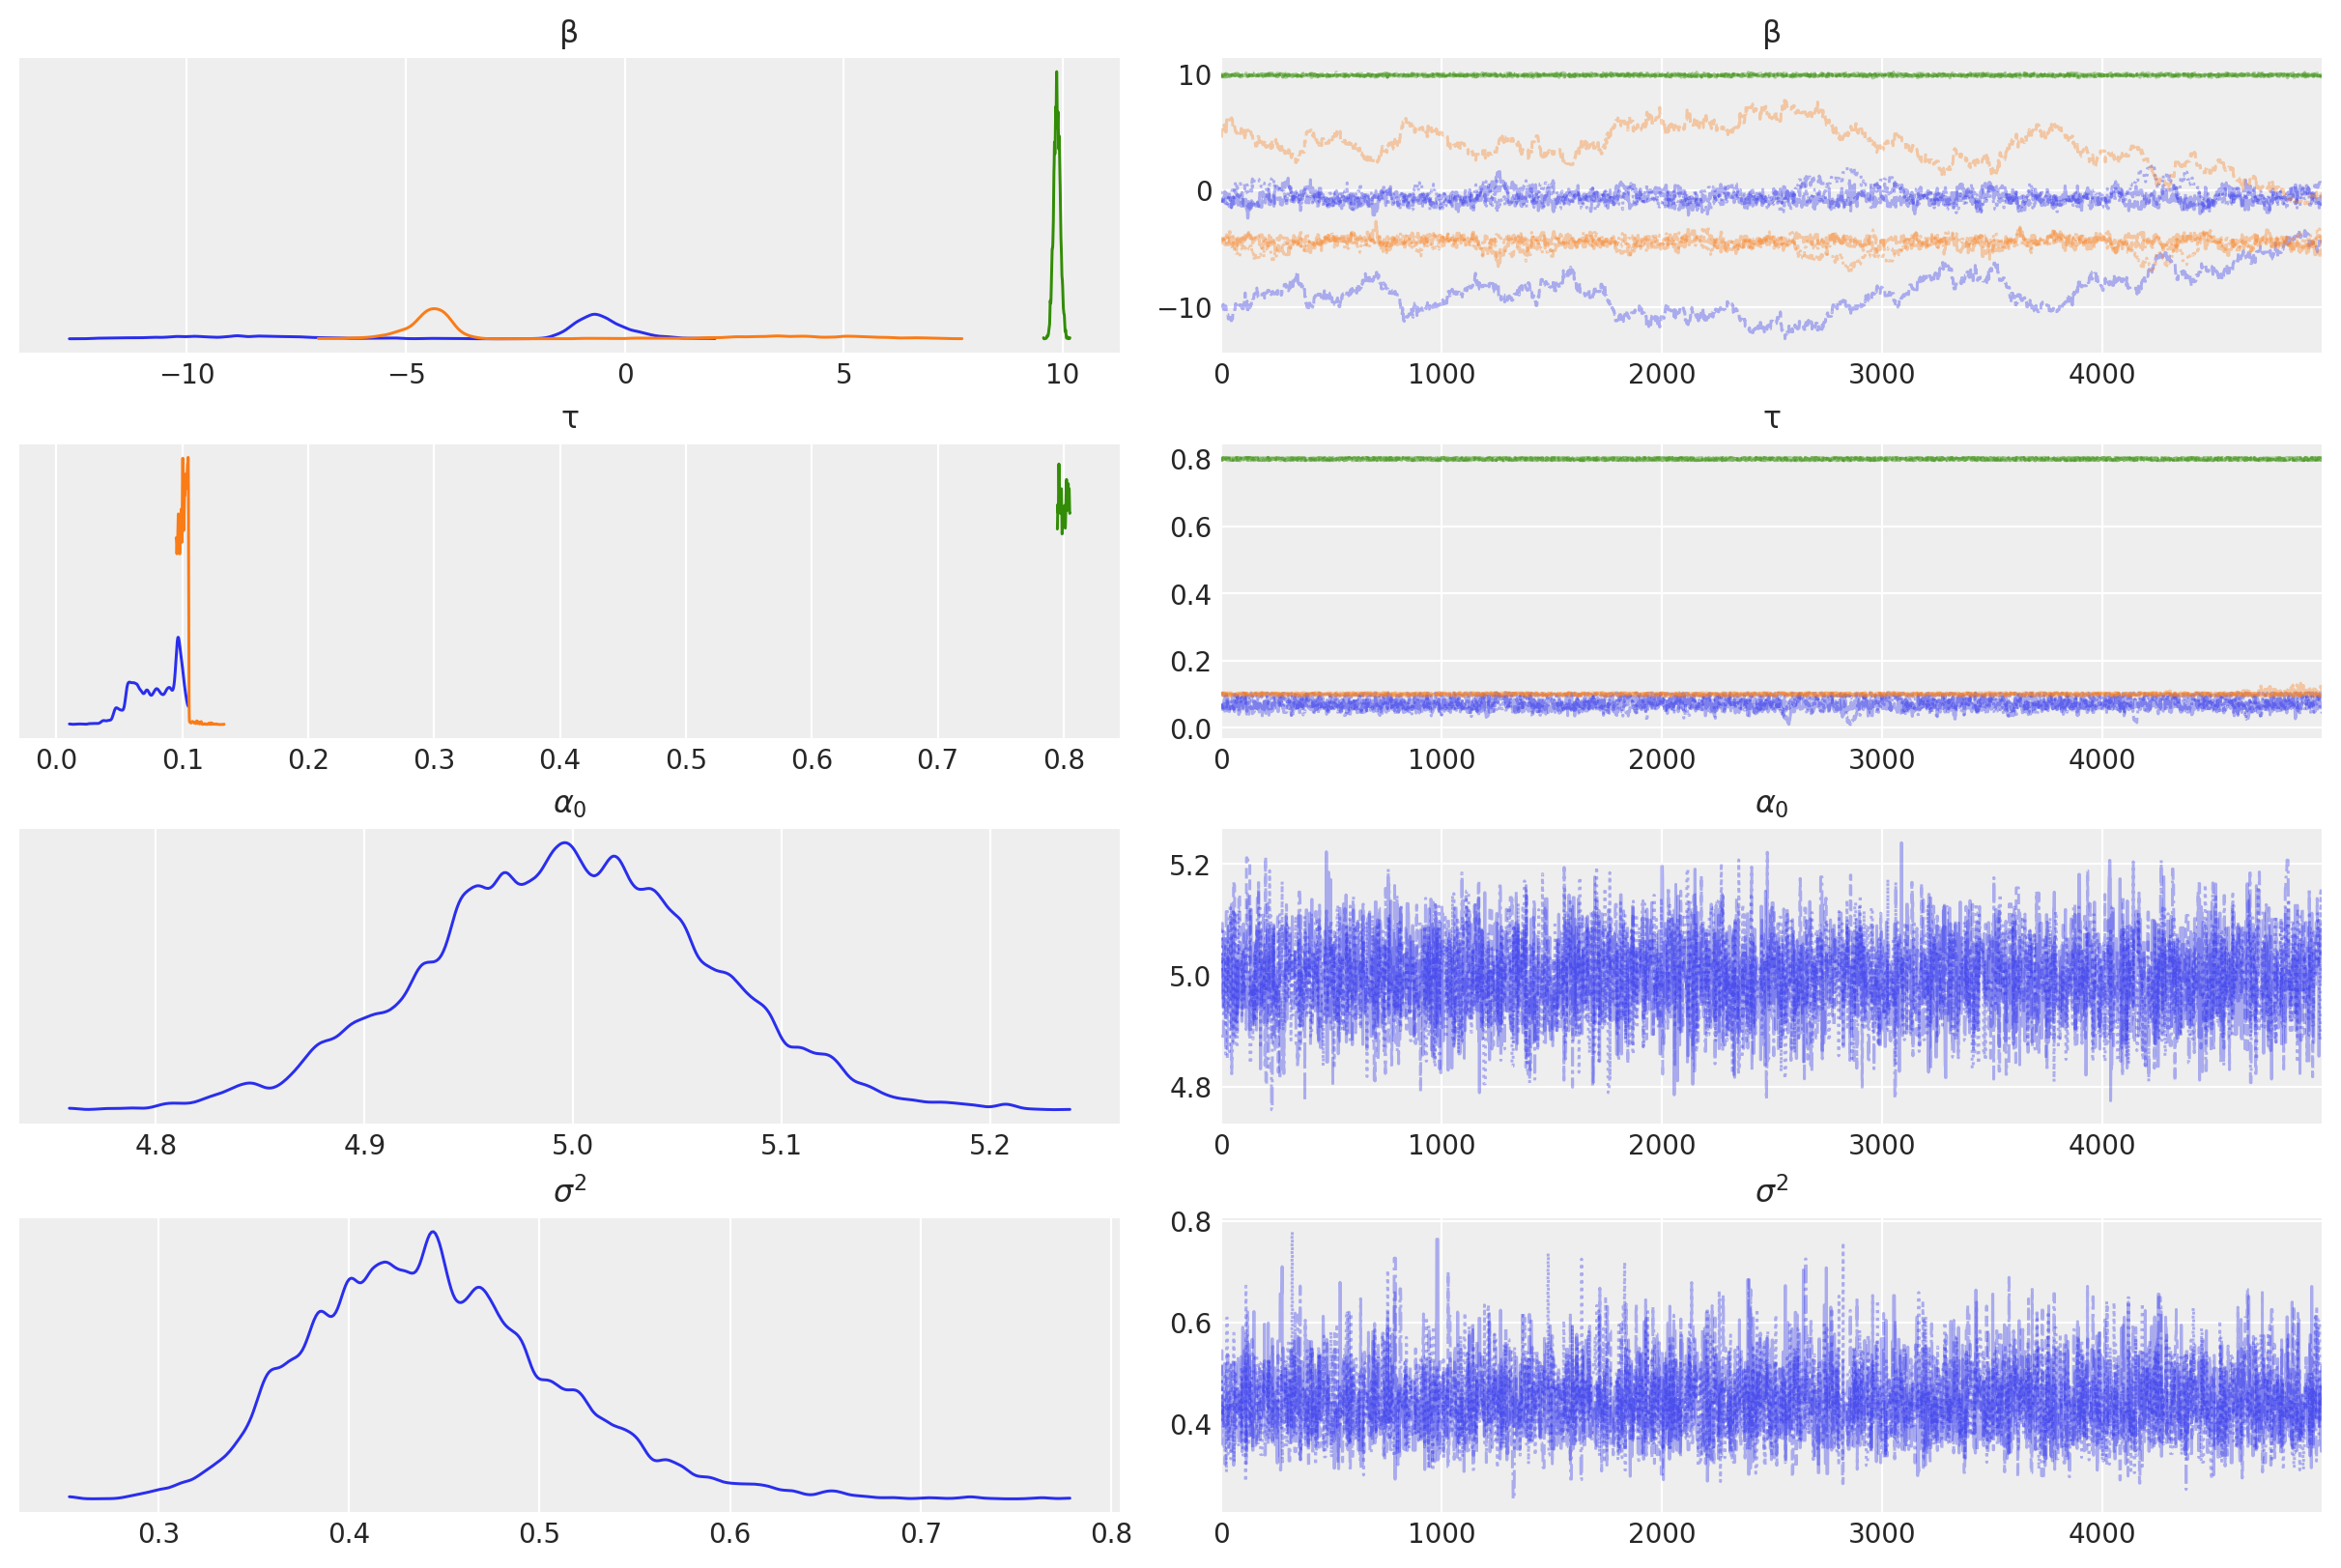

In [31]:
# -- Trace plot

az.plot_trace(
    idata_pymc,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)
print("Combined density and trace plot:")

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


Marginal posterior distributions:


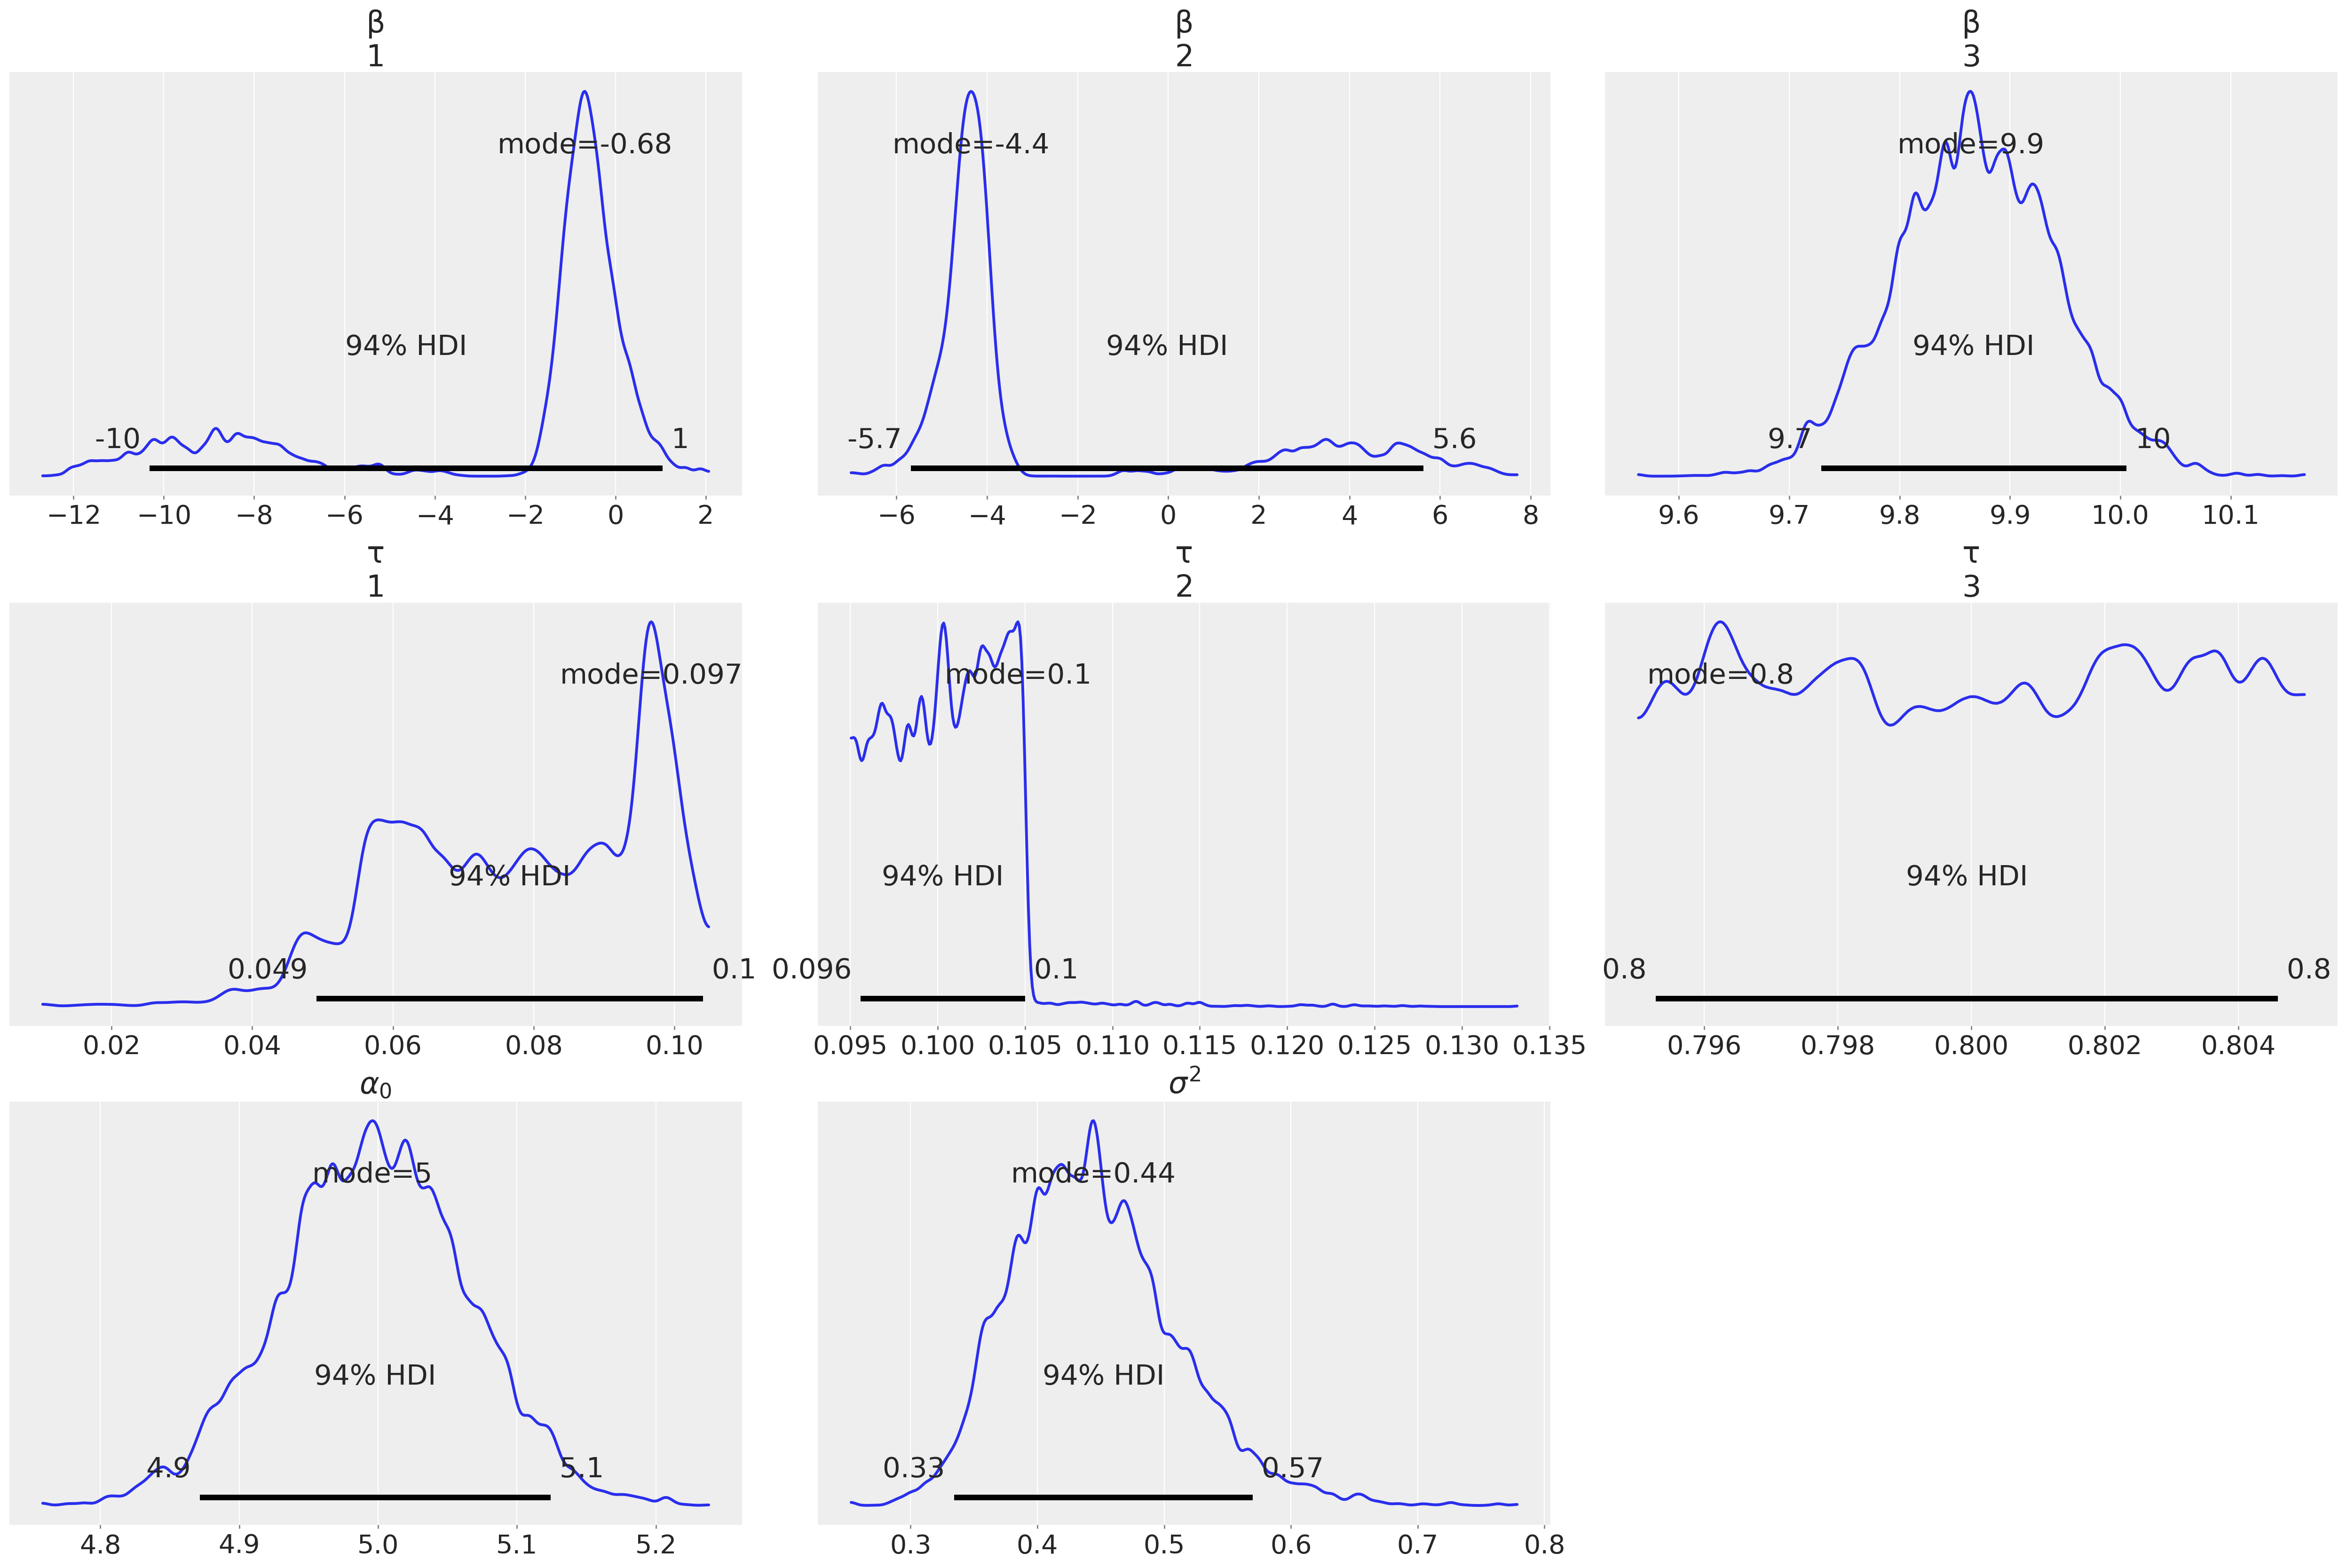

In [32]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Forest plot of 94% HDI for β and τ:


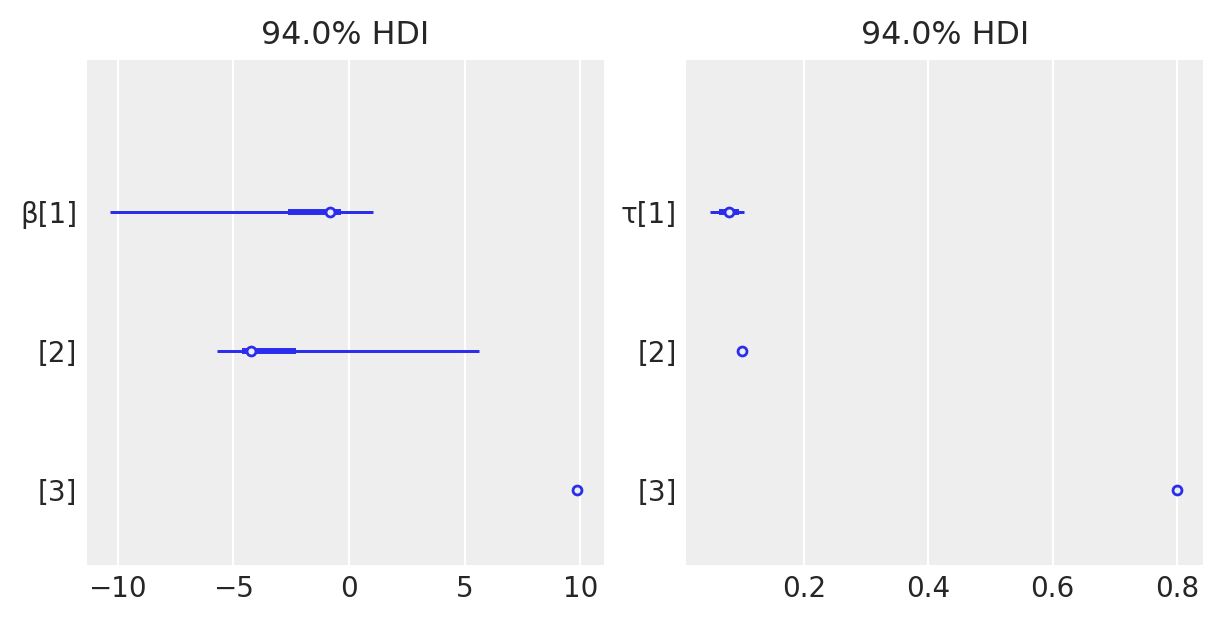

In [33]:
# -- Forest plot

plot_utils.plot_forest(
    idata_pymc,
    theta_space,
    textsize=10,
    var_names=[theta_names[theta_space.beta_idx_grouped],
               theta_names[theta_space.tau_idx_grouped]]
)

print("Forest plot of 94% HDI for β and τ:")

Generating posterior predictive samples...


/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


bpv [T=min]: 0.823
bpv [T=max]: 0.691
bpv [T=median]: 0.109
bpv [T=mean]: 0.501
bpv [T=std]: 0.376


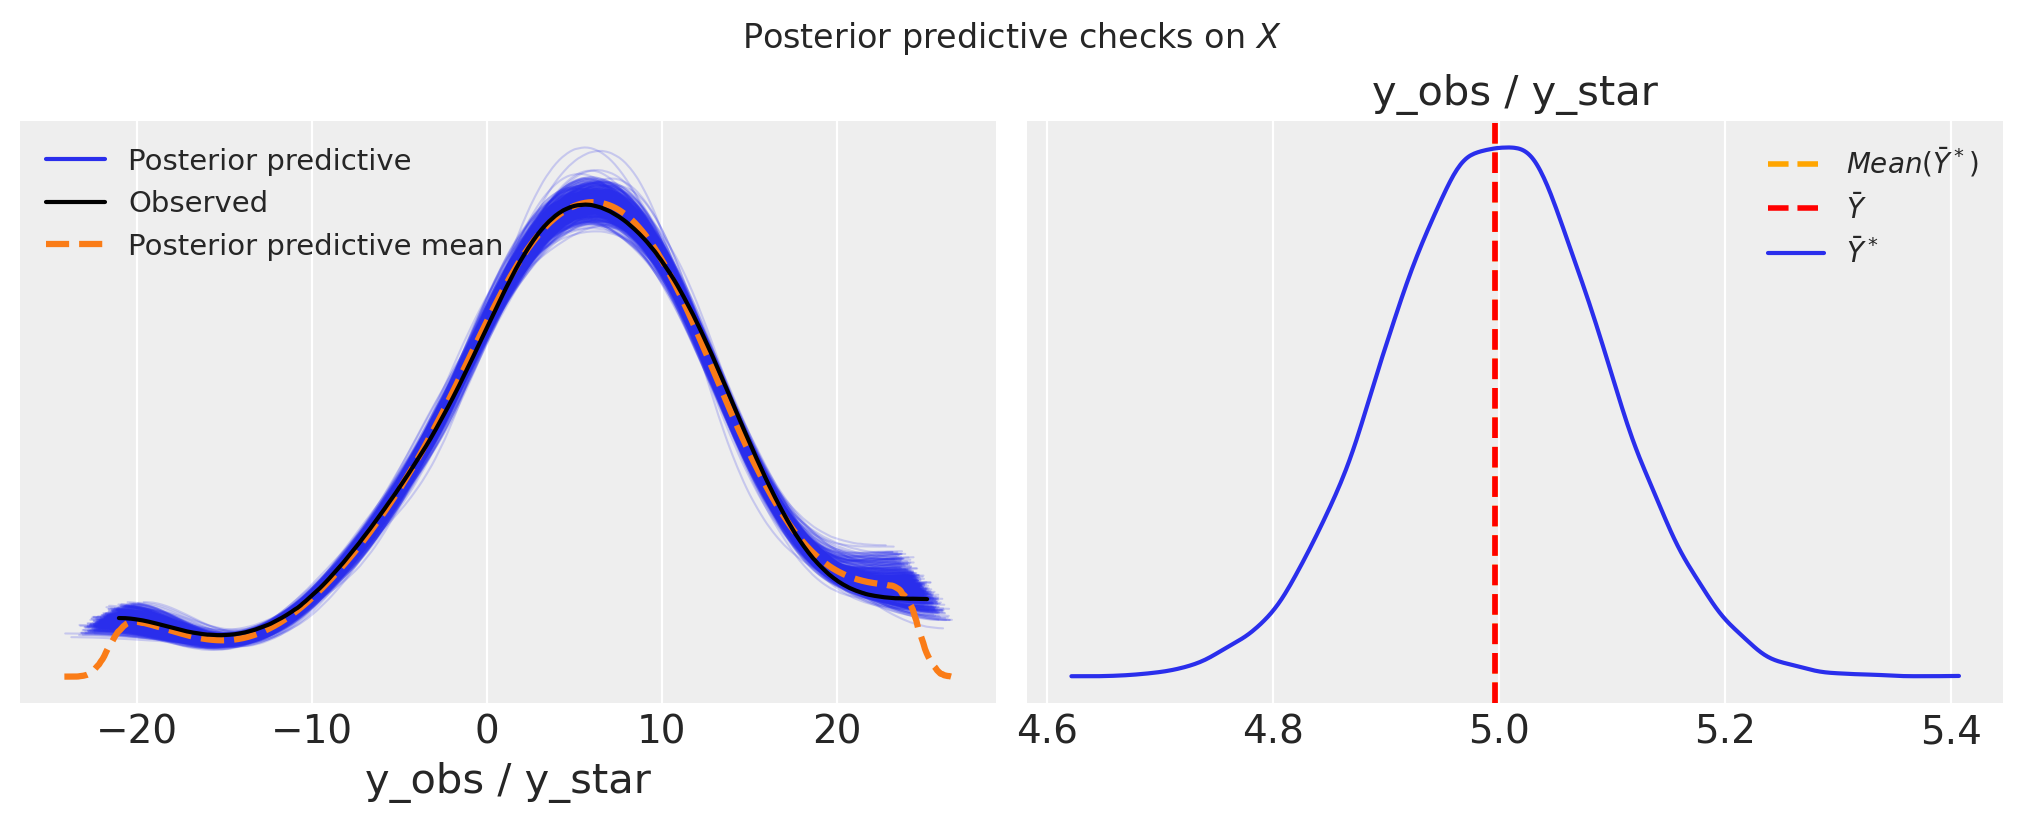

In [34]:
# -- Generate and plot posterior predictive checks from X

pp = bayesian_model.generate_pp(
    idata_pymc, X, theta_space,
    rng=rng, kind='linear', verbose=True)
pp_to_idata([pp], idata_pymc, ['y_star'], merge=True)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pymc, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


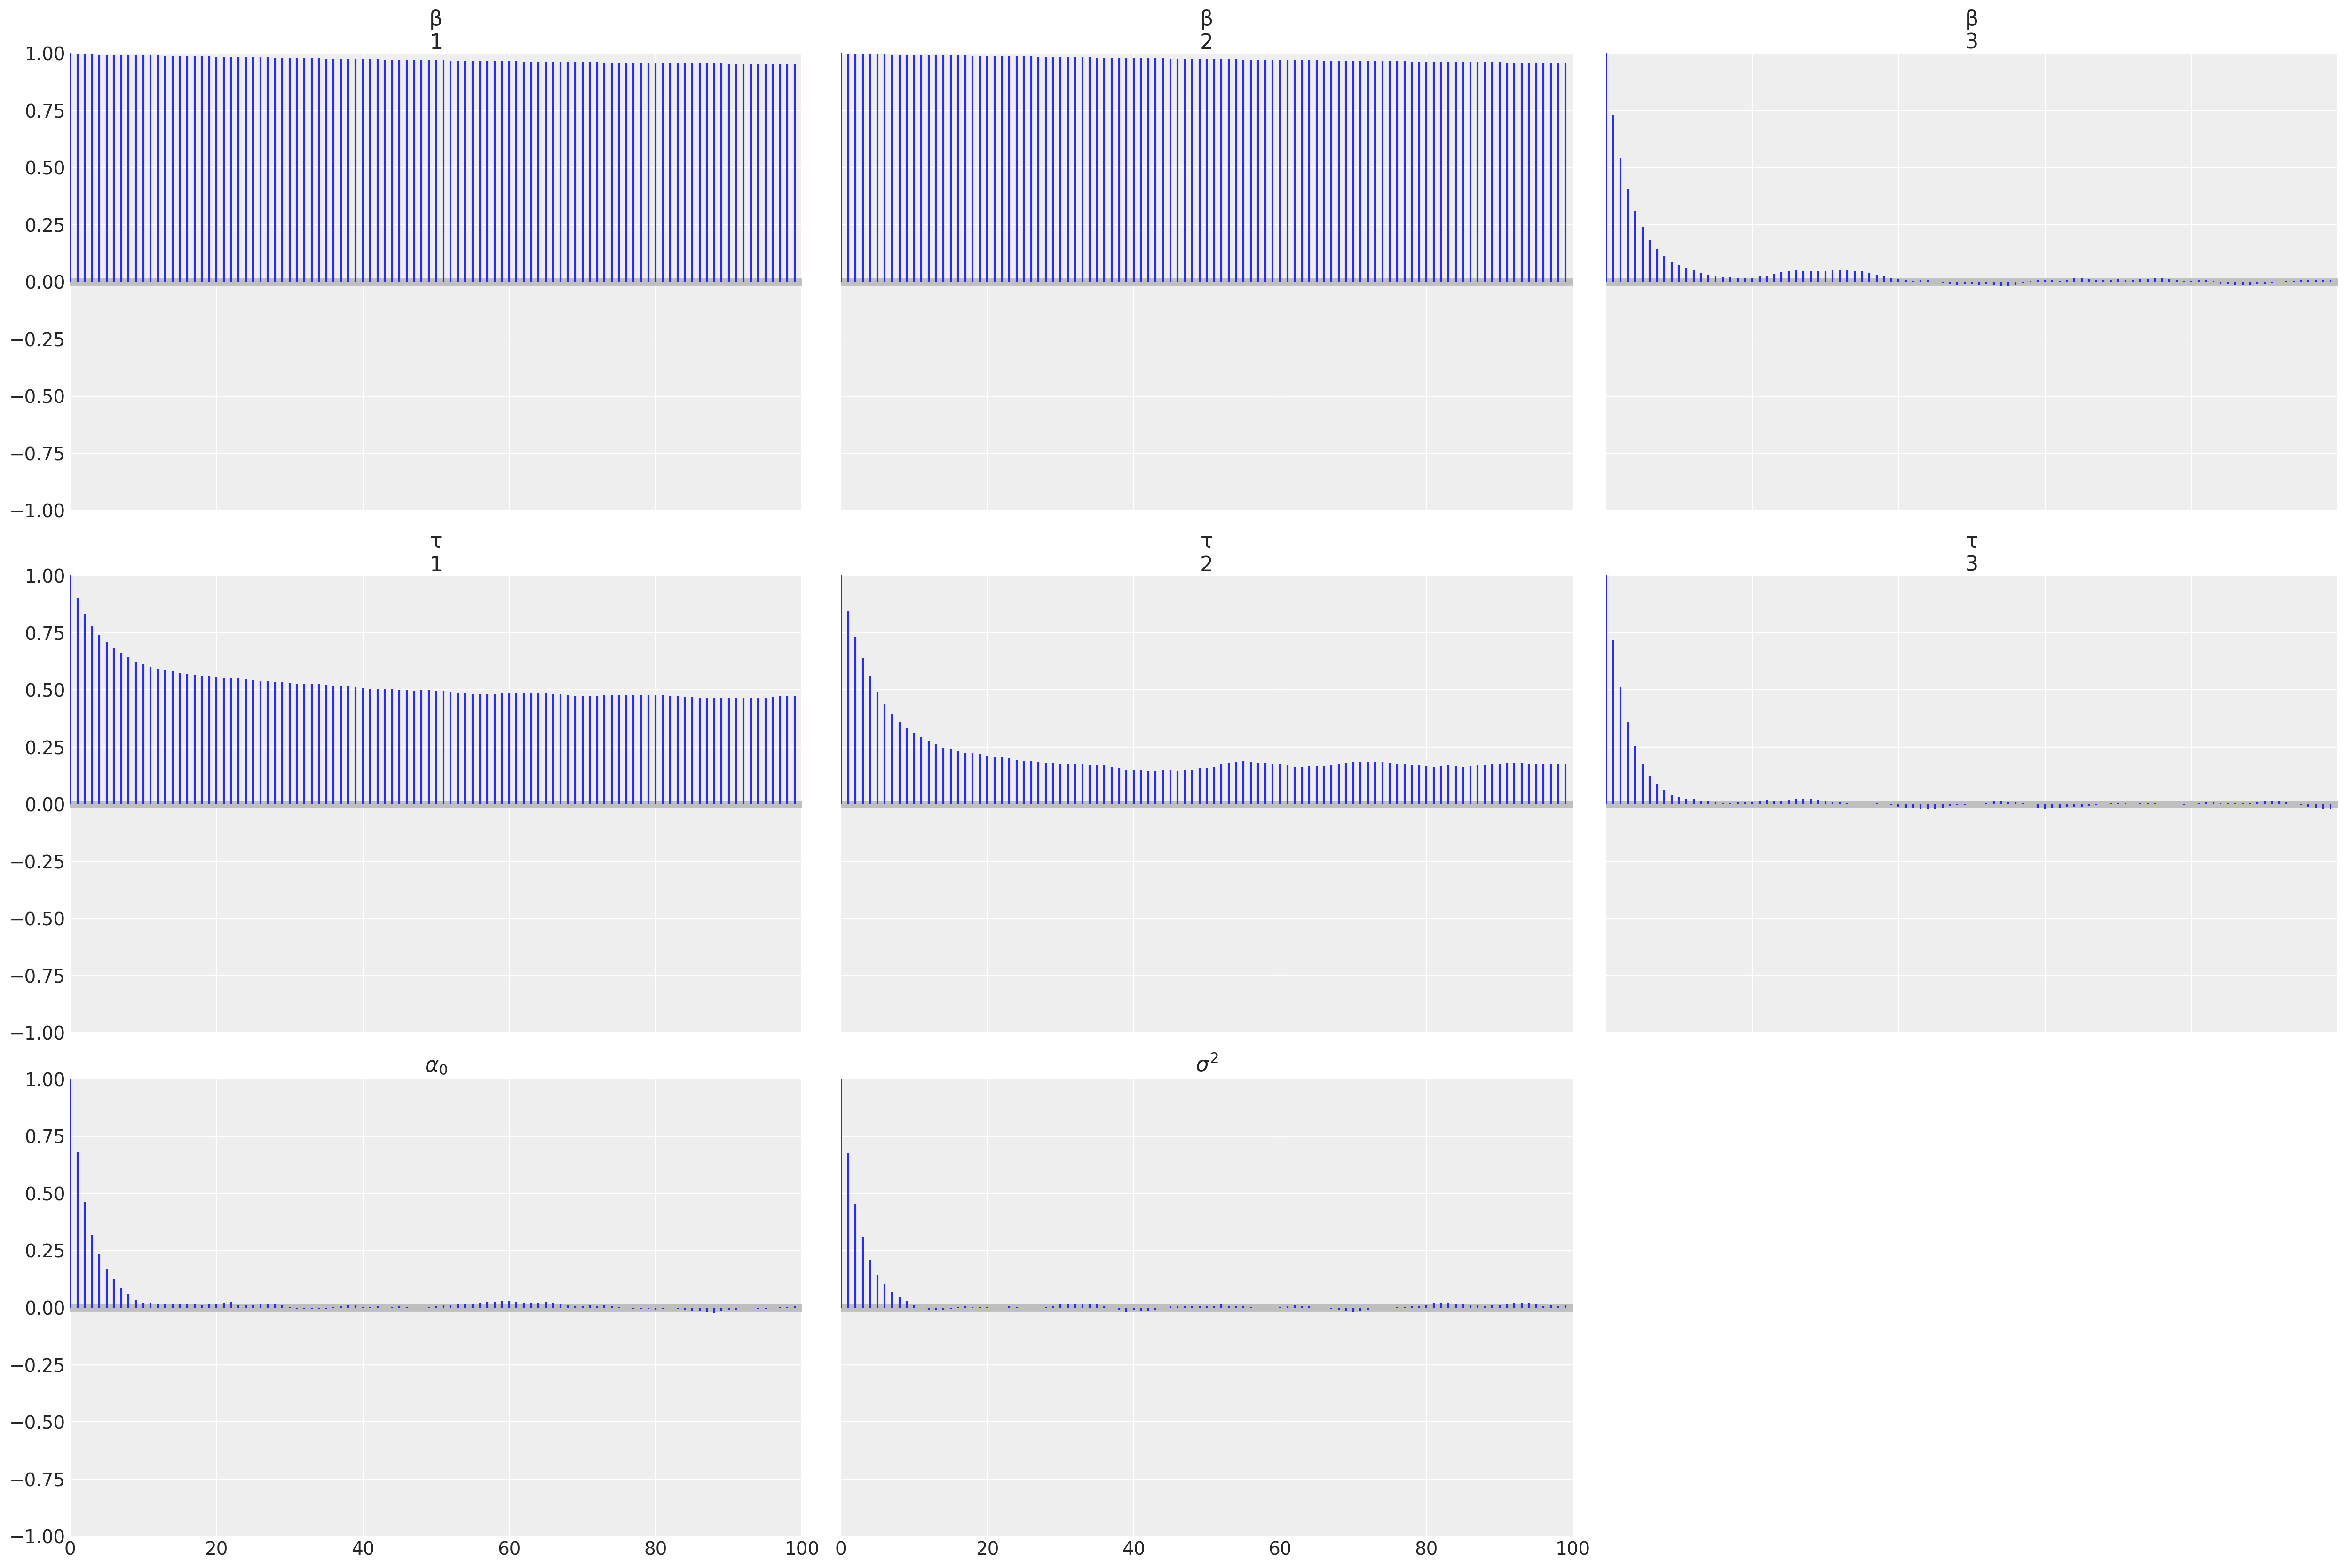

In [35]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

Graphical model:


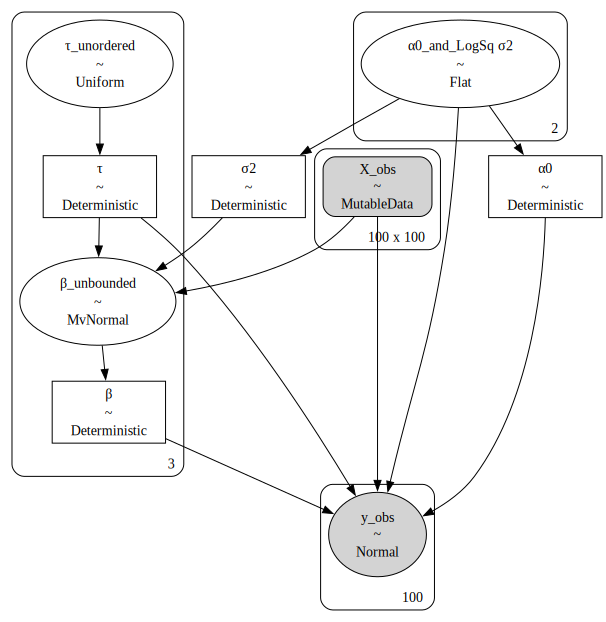

In [36]:
# -- Graphical model

print("Graphical model:")
reg_pymc.to_graphviz()

### Out-of-sample predictions

Generating posterior predictive samples...


/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


bpv [T=min]: 0.536
bpv [T=max]: 0.589
bpv [T=median]: 0.585
bpv [T=mean]: 0.140
bpv [T=std]: 0.956


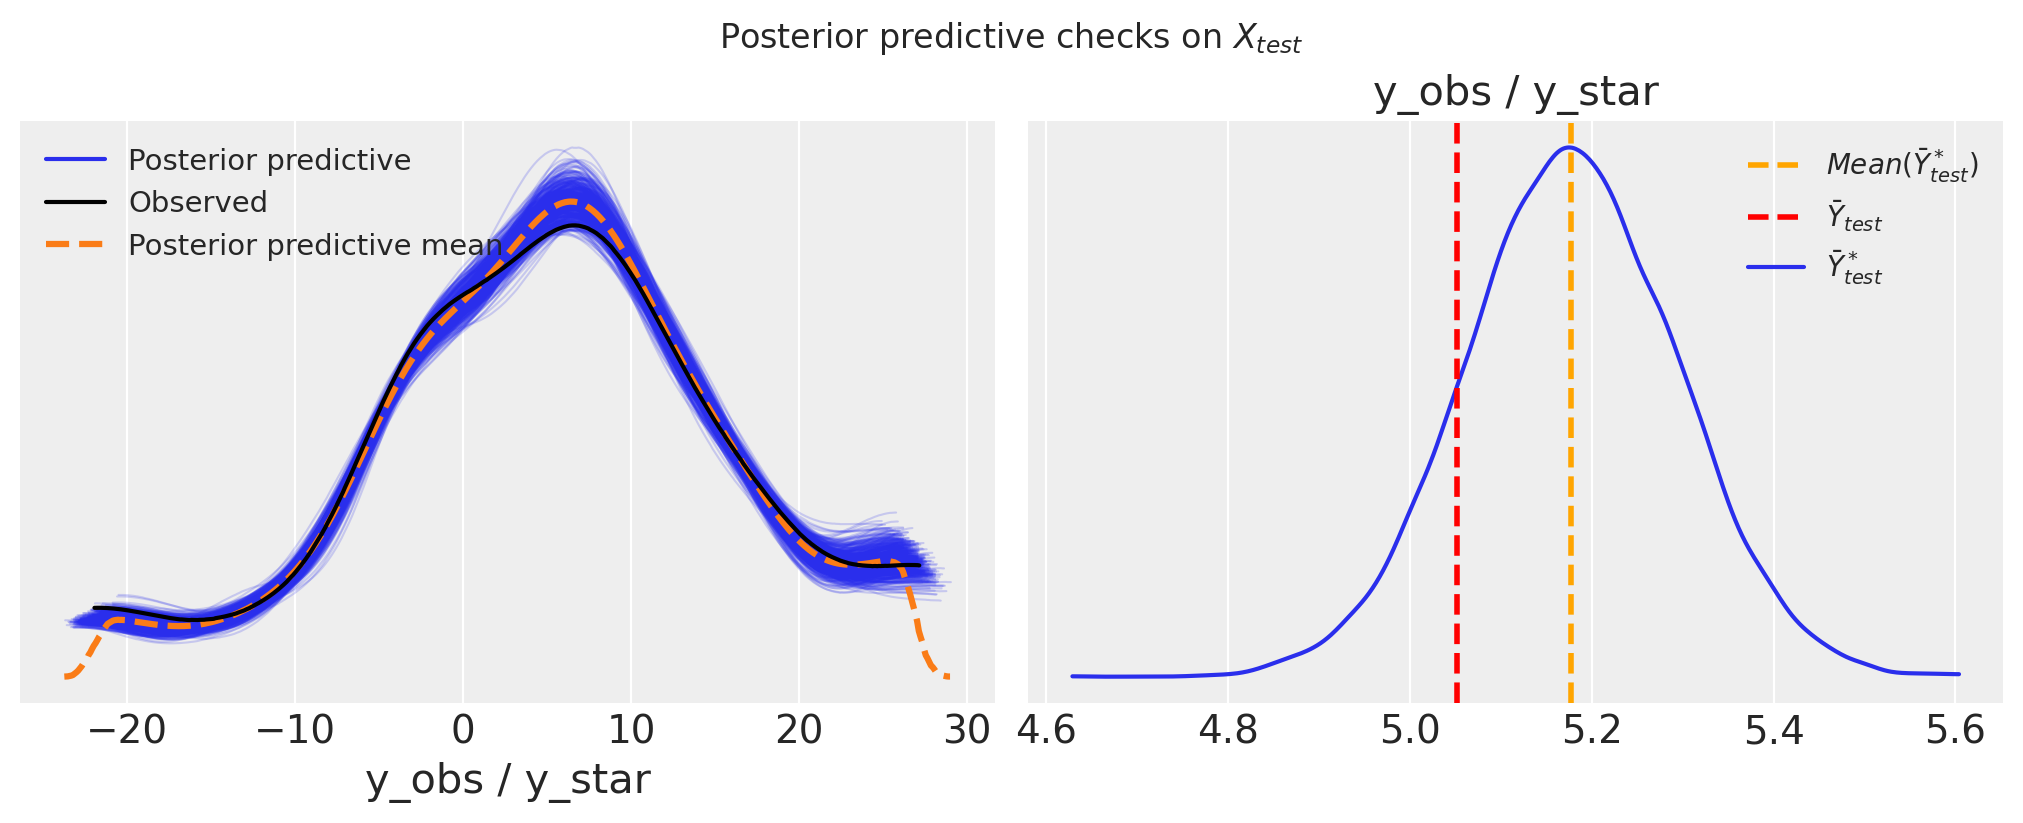

In [37]:
# -- Generate and plot posterior predictive checks from X_test

pp_test = bayesian_model.generate_pp(
    idata_pymc, X_test, theta_space,
    rng=rng, kind='linear', verbose=True)
idata_pp_test = pp_to_idata(
    [pp_test], idata_pymc, ['y_star'], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [38]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_pymc = run_utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_pymc.n_components("posterior_mean"),
    "pymc_posterior_mean"
)

# Point estimates
for pe in reg_pymc.default_point_estimates:
    Y_pred_pe = reg_pymc.predict(X_test, strategy=pe)
    df_metrics_pymc = run_utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_pymc.n_components(pe),
        "pymc_" + pe,
        df=df_metrics_pymc,
    )

df_metrics_pymc.style.hide(axis="index")

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


In [39]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = None

for pe in reg_pymc.default_point_estimates:
    X_red = reg_pymc.transform(X, pe=pe)
    X_test_red = reg_pymc.transform(X_test, pe=pe)

    df_metrics_pymc_var_sel = run_utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="pymc",
        pe=pe,
        df=df_metrics_pymc_var_sel,
        random_state=SEED,
    )

df_metrics_pymc_var_sel.style.hide(axis="index")

/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)
/home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/arviz/stats/density_utils.py:712: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = gaussian(kernel_n, bw)


### Save & Load

In [40]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-linear.nc")

In [41]:
# -- Load

idata_pymc = az.from_netcdf("pymc-linear.nc")

## Notebook metadata

In [42]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jul 30 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

numpy     : 1.26.4
matplotlib: 3.9.1
arviz     : 0.17.1
pandas    : 2.2.2
scipy     : 1.11.4
emcee     : 3.1.4
pymc      : 5.12.0

Watermark: 2.4.3

